# Import libraries

In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from matplotlib import pyplot
import pandas as pd
import pandas_datareader as pdr
import tensorflow
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import LSTM, GRU, Conv1D, MaxPooling1D, Flatten
from keras.preprocessing import sequence
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error as mse
from keras.callbacks import EarlyStopping
from sklearn.metrics import r2_score
from keras.optimizers import SGD
from keras.optimizers import Adam
import time
from sklearn import neighbors
from sklearn.ensemble import RandomForestRegressor
from sklearn.utils import shuffle
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, train_test_split, KFold, cross_val_score
from sklearn.svm import SVR, SVC
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import itertools
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
import xgboost 
from xgboost import XGBClassifier
from xgboost import XGBRegressor

/usr/local/lib/python3.6/dist-packages/pandas_datareader/compat/__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal
Using TensorFlow backend.


# Input Data from Yahoo Finance

In [2]:
DF = pdr.get_data_yahoo('spy', start = '2000-01-01', end = '2017-10-1')
DF.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2000-01-03,148.25000,143.875000,148.25000,145.4375,8164300.0,99.394493
2000-01-04,144.06250,139.640625,143.53125,139.7500,8089800.0,95.507530
2000-01-05,141.53125,137.250000,139.93750,140.0000,12177900.0,95.678391
2000-01-06,141.50000,137.750000,139.62500,137.7500,6227200.0,94.140717
2000-01-07,145.75000,140.062500,140.31250,145.7500,8066500.0,99.608055


In [0]:
#choose plotting style

#plt.style.use('fivethirtyeight')
plt.style.use('dark_background')
#plt.style.use('ggplot')
#plt.style.use('seaborn-whitegrid')
#plt.style.use('bmh')
#plt.style.use('seaborn')

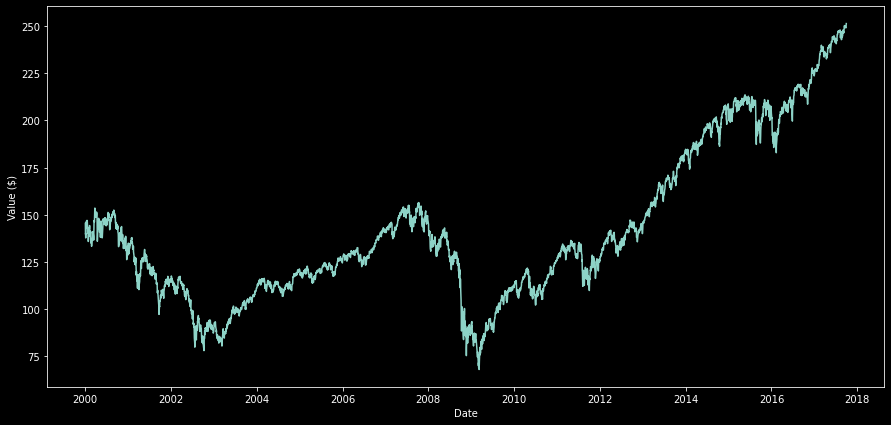

In [4]:
plt.figure(figsize=(15,7))
plt.plot(DF.Close)
plt.xlabel('Date')
plt.ylabel('Value ($)')
plt.rcParams.update({'font.size': 18})

# Define Functions

In [0]:
#creating datasets from the dataframe, make data stationary:
def difference_pct_back(datafile, lag = 1):
    diff = [0] * lag
    for i in range(lag,len(datafile)):
        diff.append(datafile[i]/datafile[i-lag]-1)
    return diff

def create_dataset_percentage_gap(dataset, window_size, look_forward, gap): #MinMaxScaler(feature_range=(0, 1)) 
    i = 0
    data_X, data_Y = [], []
    while i in range(len(dataset) - window_size - look_forward):
        a = dataset[i:(i + window_size), :]
        data_X.append(a)
        b = dataset[i + window_size + look_forward-1, 0]/dataset[i+window_size-1,0]-1
        data_Y.append(b)
        i += gap
        
    x = np.array(data_X)
    y = np.array(data_Y)
    y = y.reshape(-1,1)
    return (x,y)

def create_dataset_difference_gap(dataset, window_size, look_forward, gap): #MinMaxScaler(feature_range=(0, 1)) 
    i = 0
    data_X, data_Y = [], []
    while i in range(len(dataset) - window_size - look_forward):
        a = dataset[i:(i + window_size), :]
        data_X.append(a)
        b = dataset[i + window_size + look_forward-1, 0]-dataset[i+window_size-1,0]
        data_Y.append(b)
        i += gap
        
    x = np.array(data_X)
    y = np.array(data_Y)
    y = y.reshape(-1,1)
    return (x,y)

#regression to classification:
def y_classifier(array, threshold):
    classes = []
    for i in range(len(array)):
        if array[i,0] > threshold:
            classes.append(1)
        elif array[i,0] < -1*threshold:
            classes.append(-1)
        else:
            classes.append(0)
    return np.asarray(classes)

#defining moving averages:
def EMA(df, EMA_days):
    sma = np.mean(df[0:EMA_days])
    EMA_list = [0] * (EMA_days - 1)
    EMA_list.append(sma)
    c = 2/(1+EMA_days)
    for i in range(EMA_days,len(df)):
        a = EMA_list[i-1]*(1-c)+ c*df[i]
        EMA_list.append(a)
    return(EMA_list)

def SMA(df, sma_days):
    sma_list = [0] * (sma_days - 1)
    for i in range(sma_days, len(df)+1):
        sma_list.append(np.mean(df[i-sma_days:i]))
    return(sma_list)

#defining some metrics
def rms(y, pred):
    temp = 0
    if len(y) != len(pred):
        return False
    else:
        for i in range(len(y)):
            temp += (y[i][0] - pred[i][0])**2
        return temp/len(y) 

def smape(A, F):
    return 100/len(A) * np.sum(2 * np.abs(F - A) / (np.abs(A) + np.abs(F)+0.0000000001))

def mae(A, F):
    return 1/len(A) * np.sum(np.abs(F - A))

#autocorrelation benchmark:
def benchmark(y, look_forward):
    Y_hat = []
    Y_real = []
    for i in range(2*look_forward, len(y)):
        a = np.mean(y[i-2*look_forward:i-look_forward,0])
        Y_hat.append(a)
        Y_real.append(y[i,0])
    return (np.asarray(Y_real), np.asarray(Y_hat))


def pretty_print_conf_matrix(y_true, y_pred, classes,normalize=False,title='Confusion matrix',cmap=plt.cm.Blues):
    cm = confusion_matrix(y_true, y_pred)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=14)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    plt.ylabel('True label', fontsize=12)
    plt.xlabel('Predicted label', fontsize=12)
    if normalize:
        cm = np.round(cm.astype('float') / cm.sum(),2) 
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],horizontalalignment="center",color="white" if cm[i, j] > thresh else "black",
                 fontsize=12)
        
def plot(y_train, prediction_train,y_test, prediction_test):
    fig = plt.figure()
    plt.rcParams.update({'font.size': 18})
    plt.figure(figsize=(15,5))
    plt.subplot(1, 2, 1)
    plt.scatter(y_train, prediction_train)
    plt.ylabel('predicted')
    plt.xlabel('actual')
    plt.title('ML-Train')


    plt.subplot(1, 2, 2)
    plt.scatter(y_test, prediction_test)
    plt.ylabel('predicted')
    plt.xlabel('actual')
    plt.title('ML-Test')
    plt.show()

    plt.figure(figsize=(15,8))
    plt.subplot(2, 1, 1)
    plt.plot(prediction_train, marker = '*',linestyle="None", label = 'Pred')
    plt.plot(y_train, marker = '.', label = 'Y', linestyle="None")
    plt.grid()
    plt.legend()
    plt.title('Train')
    plt.subplots_adjust(hspace = 0.4)

    plt.subplot(2, 1, 2)
    plt.plot(prediction_test, marker = '*', label = 'Pred',linestyle="None")
    plt.plot(y_test, marker = '.',linestyle="None" , label = 'Y')
    plt.grid()
    plt.legend()
    plt.title('Test')

#this function changes 1D y array to an array with 3 features that is used for softmax
def y_softmax(array):
    lst = []
    for i in range(len(array)):
        if array[i] == 1:
            lst.append([1,0,0])
        elif array[i] == 0:
            lst.append([0,1,0])
        else:
            lst.append([0,0,1])
    return np.asarray(lst)

        
def softmaxifier(array):
    zeros = [0, 0, 0]
    pred = []
    for i in range(len(array)):
        j = np.argmax(array[i])
        temp = [0,0,0]
        temp[j] = 1
        pred.append(temp)
    return pred

#this function changes 3D y array with 3 features that was generated by softmax to an 1D array for confusion matrix
def desoftmaxer(array):
    lst = []
    for i in range(len(array)):
        if np.argmax(array[i]) == 0:
            lst.append(1)
        elif np.argmax(array[i]) == 1:
            lst.append(0)
        else:
            lst.append(-1)
    return (np.asarray(lst))
#fix random effect
def fix_rnd_Keras():
    seed_value= 0
    import os
    os.environ['PYTHONHASHSEED']=str(seed_value)
    import random
    random.seed(seed_value)
    import numpy as np
    np.random.seed(seed_value)
    import tensorflow as tf
    tf.set_random_seed(seed_value)
    from keras import backend as K
    session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
    sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
    K.set_session(sess)

#split x and y to test and train that are devisible to batch_size
def test_train_split(x, y, batch_size, train_ratio):       
    train_length = int(len(x)*train_ratio)
    for i in range(train_length, train_length+batch_size):
        remainder = i%batch_size
        if remainder == 0:
            train_length = i
            break
    x_train = x[:train_length,:]
    y_train = y[:train_length]

    for i in range(len(x)-batch_size, len(x)):
        remainder = i%batch_size
        if remainder == 0:
            train_length_test = i
            break
    x_test = x[train_length:train_length_test,:]
    y_test = y[train_length:train_length_test]
    return x_train, y_train, x_test, y_test

# Creating Features

In [0]:
df = DF.Close
df = df.dropna(axis=0, how='any')

#making moving averages
v_10 = SMA(DF.Volume, 10)
v_20 = SMA(DF.Volume, 20)
open_close = (DF.Close/DF.Open - 1).tolist()
high_low = (DF.High/DF.Low - 1).tolist()
EMA_8 = EMA(df,8)
SMA_10 = SMA(df,10)
SMA_20 = SMA(df,20)
SMA_50 = SMA(df,50)
SMA_100 = SMA(df,100)
pct_day = difference_pct_back(df, 1)
list_df = df.tolist()
vol_list = DF.Volume.tolist()
MAs = pd.DataFrame(list(zip(list_df, pct_day, vol_list, v_10, v_20,open_close,high_low, EMA_8, SMA_10, 
                            SMA_20, SMA_50, SMA_100)),columns=['spot', 'pct_day', 'vol', 'v_10', 'v_20',
                            'open_close', 'high_low', 'EMA_8', 'SMA_10', 'SMA_20', 'SMA_50','SMA_100'])

#removing all rows with 0 in them
MAs = MAs[100:]
MAs = MAs.reset_index(drop=True)

#making differences as features
MAs['v10'] = MAs.vol/MAs.v_10 - 1
MAs['v20'] = MAs.vol/MAs.v_20 - 1
MAs['spot_EMA'] = MAs.spot/MAs.EMA_8 - 1
MAs['spot_20SMA'] = MAs.spot/MAs.SMA_20 - 1
MAs['spot_50SMA'] = MAs.spot/MAs.SMA_50 - 1
MAs['spot_100SMA'] = MAs.spot/MAs.SMA_100 - 1
MAs['10_100_SMA'] = MAs.SMA_10/MAs.SMA_100 - 1
MAs['20_50_SMA'] = MAs.SMA_20/MAs.SMA_50 - 1
MAs = MAs.drop(['EMA_8', 'SMA_10', 'SMA_20', 'SMA_50', 'SMA_100', 'v_10', 'v_20'], 1)

# Initial Visualization

,spot,pct_day,vol,open_close,high_low,v10,v20,spot_EMA,spot_20SMA,spot_50SMA,spot_100SMA,10_100_SMA,20_50_SMA
0,137.84375,-0.017157,8278900.0,-0.020213,0.029725,0.126006,0.078444,-0.018766,-0.031364,-0.053232,-0.035971,-0.006489,-0.022577
1,138.00000,0.001134,4814000.0,-0.005853,0.017181,-0.334878,-0.356438,-0.013785,-0.027843,-0.051072,-0.034760,-0.009733,-0.023894
2,142.50000,0.032609,5362700.0,0.017857,0.024871,-0.268381,-0.273540,0.014233,0.005474,-0.019530,-0.003459,-0.011851,-0.024868
3,142.81250,0.002193,6056500.0,0.001754,0.013415,-0.148930,-0.160474,0.012753,0.008146,-0.016923,-0.001628,-0.014910,-0.024866
4,145.31250,0.017505,8961600.0,0.011309,0.017045,0.207473,0.274632,0.023549,0.024144,0.000820,0.015881,-0.014771,-0.022775


<Figure size 432x288 with 0 Axes>

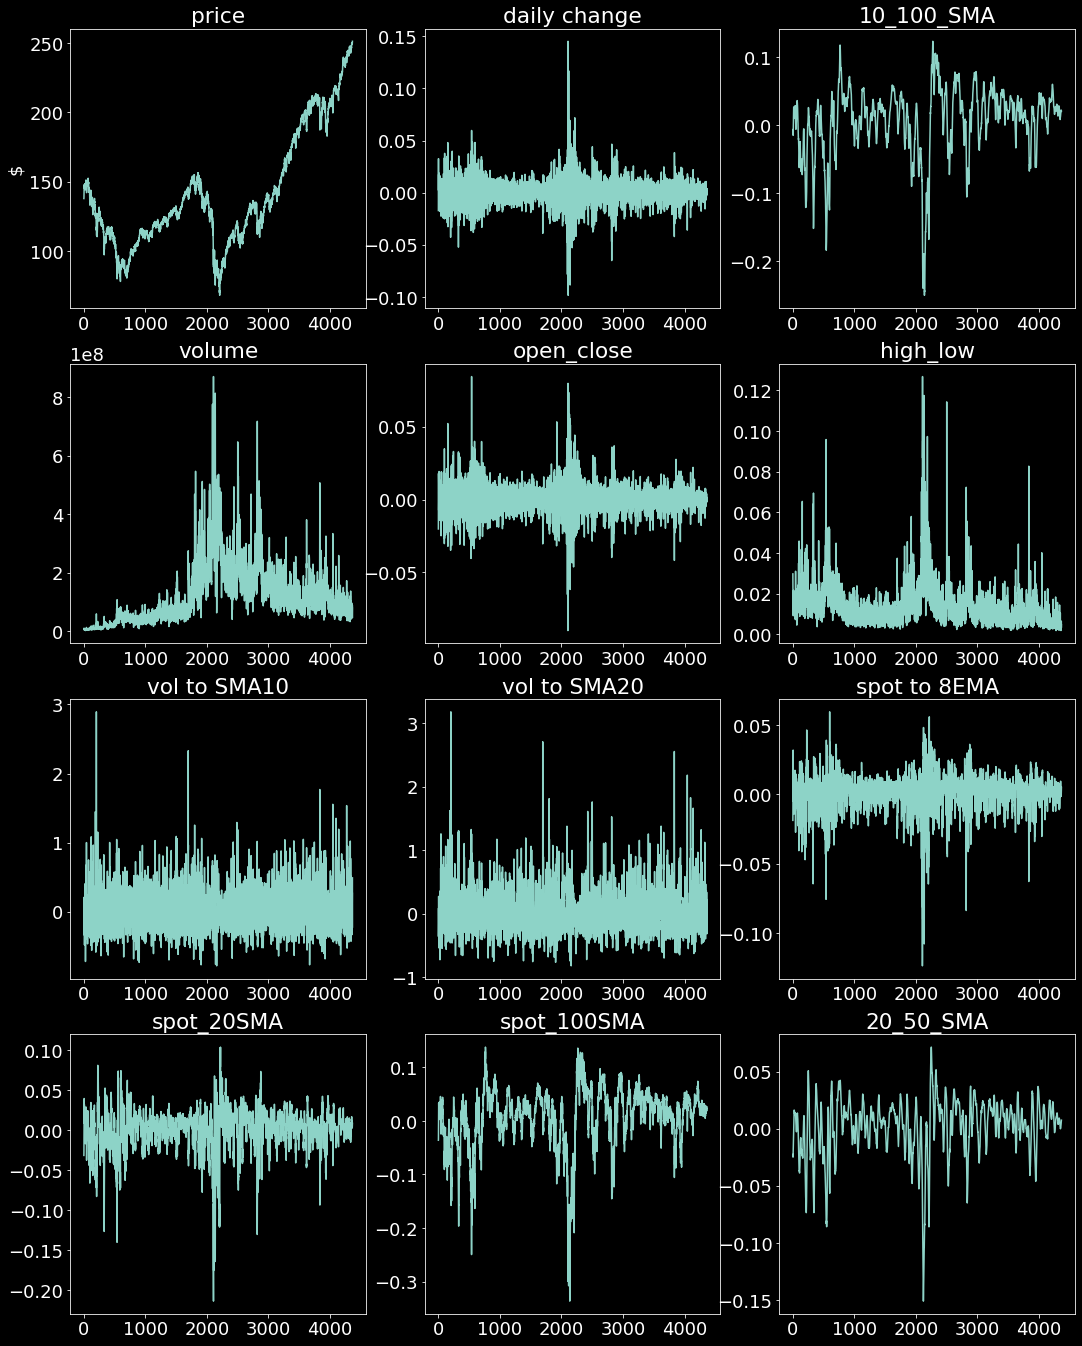

In [7]:
fig = plt.figure()
plt.figure(figsize=(18,14))
           
plt.subplot(4, 3, 1)
plt.plot(MAs.spot)
plt.ylabel('$')
plt.title('price')
          
plt.subplot(4, 3, 2)
plt.plot(MAs.pct_day)
plt.title('daily change')

plt.subplot(4, 3, 3)
plt.plot(MAs['10_100_SMA'])
plt.title('10_100_SMA')

plt.subplot(4, 3, 4)
plt.plot(MAs.vol)
plt.title('volume')
plt.subplots_adjust(top = 1.4)

plt.subplot(4, 3, 5)
plt.plot(MAs.open_close)
plt.title('open_close')

plt.subplot(4, 3, 6)
plt.plot(MAs.high_low)
plt.title('high_low')

plt.subplot(4, 3, 7)
plt.plot(MAs.v10)
plt.title('vol to SMA10')

plt.subplot(4, 3, 8)
plt.plot(MAs.v20)
plt.title('vol to SMA20')

plt.subplot(4, 3, 9)
plt.plot(MAs.spot_EMA)
plt.title('spot to 8EMA')

plt.subplot(4, 3, 10)
plt.plot(MAs.spot_20SMA)
plt.title('spot_20SMA')

plt.subplot(4, 3, 11)
plt.plot(MAs.spot_100SMA)
plt.title('spot_100SMA')

plt.subplot(4, 3, 12)
plt.plot(MAs['20_50_SMA'])
plt.title('20_50_SMA')
MAs.head(5)

# Creating a Benchmark

r2_score =  -0.6908392844289526


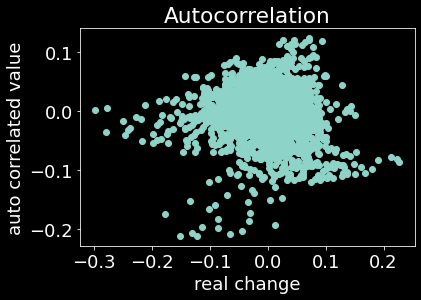

In [8]:
window_size = 1
look_forward =20
scaler = MinMaxScaler(feature_range=(0.00001, 1)) 
MAs_scaled = scaler.fit_transform(MAs)
x, y_scaled = create_dataset_percentage_gap(MAs_scaled, window_size, look_forward, 1)
MAs_array = MAs.values
x_scaled, y = create_dataset_percentage_gap(MAs_array, window_size, look_forward, 1)
y1, y2 = benchmark(y,look_forward)
plt.scatter(y1,y2)
plt.ylabel('auto correlated value')
plt.xlabel('real change')
plt.title('Autocorrelation')
print('r2_score = ', r2_score(y1,y2))

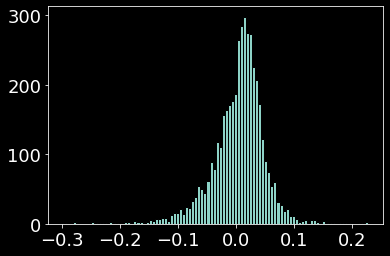

In [9]:
plt.hist(y1, bins = 100, edgecolor = 'black', histtype='bar');

# KNN Regression

In [10]:
train_ratio = 0.8
window_size = 1
look_forwards = [20]
batch_size = 16 

look_forward_table, time_table, smape_test, smape_train, mae_train, mae_test = [], [], [], [], [], []
K_value, mse_train, mse_test, r2_train, r2_test = [], [], [], [], []

for look_forward in look_forwards:
    start_time = time.time()
    scaler = MinMaxScaler(feature_range=(0.00001, 1)) 
    MAs_scaled = scaler.fit_transform(MAs)
    x, y_scaled = create_dataset_percentage_gap(MAs_scaled, window_size, look_forward,1)
    MAs_array = MAs.values
    x_scaled, y = create_dataset_percentage_gap(MAs_array, window_size, look_forward,1)

#split to train and CV
    x = x.reshape(len(x), -1)
    x_train, y_train, x_test, y_test = test_train_split(x, y, batch_size, train_ratio)

    for K in range(1,2):
        K = K+1
        K_value.append(K)
        model = neighbors.KNeighborsRegressor(n_neighbors = K)
        model.fit(x_train, y_train)  
        prediction_train = model.predict(x_train)
        prediction_test = model.predict(x_test)
        accuracy_train_smape = round(smape(prediction_train, y_train), 2)
        accuracy_test_smape = round(smape(prediction_test, y_test), 2)
        accuracy_train_mse = round(mse(prediction_train, y_train), 5)
        accuracy_test_mse = round(mse(prediction_test, y_test), 5)
        accuracy_train_r2 = round(r2_score(prediction_train, y_train), 2)
        accuracy_test_r2 = round(r2_score(prediction_test, y_test), 2)
        accuracy_train_mae = round(mae(prediction_train, y_train), 4)
        accuracy_test_mae = round(mae(prediction_test, y_test), 4)
        smape_train.append(accuracy_train_smape)
        smape_test.append(accuracy_test_smape)
        mse_train.append(accuracy_train_mse)
        mse_test.append(accuracy_test_mse)
        r2_train.append(accuracy_train_r2)
        r2_test.append(accuracy_test_r2)
        mae_train.append(accuracy_train_mae)
        mae_test.append(accuracy_test_mae)
        end_time = time.time()
        time_table.append(round(end_time - start_time,2))
        look_forward_table.append(look_forward)


hyper_parameters = pd.DataFrame(list(zip(K_value,look_forward_table, time_table, smape_train, smape_test, mae_train,
                                         mae_test, mse_train, mse_test, r2_train, r2_test)),
        columns =['k', 'look_forward', 'time', 'smape_train', 'smape_test',
                  'mae_train', 'mae_test', 'mse_train', 'mse_test', 'r2_train', 'r2_test'])
hyper_parameters = hyper_parameters.sort_values(by=['smape_train'], ascending=True)
hyper_parameters = hyper_parameters.reset_index(drop=True)
hyper_parameters

,k,look_forward,time,smape_train,smape_test,mae_train,mae_test,mse_train,mse_test,r2_train,r2_test
0,2,20,0.13,56.96,136.6,0.0128,0.0227,0.00044,0.001,0.76,-1.63


<Figure size 432x288 with 0 Axes>

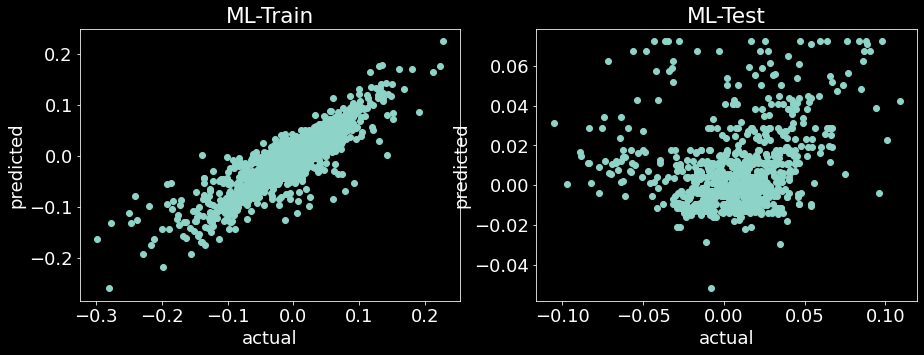

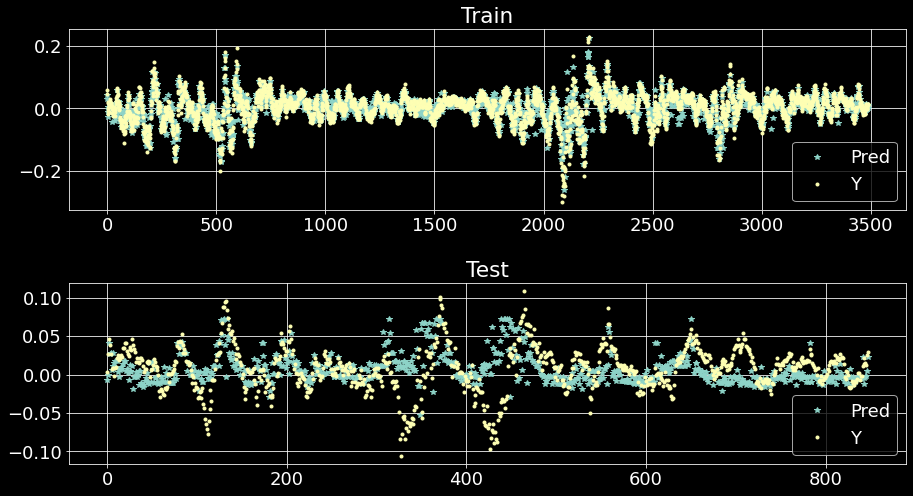

In [11]:
plot(y_train, prediction_train,y_test, prediction_test)

# KNN Classification

In [12]:
train_ratio = 0.8
window_size = 1
batch_size = 8

train = []
test = []
k = []
long_prec ,cash_prec, short_prec, long_recal, cash_recal, short_recal, long_prec_tr =  [],[],[],[],[],[],[]
cash_prec_tr, short_prec_tr, long_recal_tr, cash_recal_tr, short_recal_tr, long_fscores =  [], [], [], [], [], []

look_forwards = [20]

for look_forward in look_forwards:
    start_time = time.time()
    scaler = MinMaxScaler(feature_range=(0.00001, 1)) 
    MAs_scaled = scaler.fit_transform(MAs)
    x, y_scaled = create_dataset_percentage_gap(MAs_scaled, window_size, look_forward,1)
    MAs_array = MAs.values
    x_scaled, y = create_dataset_percentage_gap(MAs_array, window_size, look_forward,1)
    y = y_classifier(y, 0.02)
    x = x.reshape(len(x), -1)
    x_train, y_train, x_test, y_test = test_train_split(x, y, batch_size, train_ratio)

    for K in range(58,59):
        K = K+1
        k.append(K)
        model = neighbors.KNeighborsClassifier(n_neighbors = K)
        model.fit(x_train, y_train)  
        prediction_train = model.predict(x_train)
        prediction_test = model.predict(x_test)
        rpt = classification_report(y_test, prediction_test, target_names = ['short', 'cash', 'long'],
                                                    output_dict=True )
        long_precision =  rpt['long']['precision']
        long_fscore = rpt['long']['f1-score']
        cash_precision =  rpt['cash']['precision']
        short_precision =  rpt['short']['precision']
        long_rec =  rpt['long']['recall']
        cash_rec =  rpt['cash']['recall']
        short_rec =  rpt['short']['recall']
        rptt = classification_report(y_train, prediction_train, target_names = ['short','cash','long'], 
                                     output_dict=True )
        long_precision_t =  rptt['long']['precision']
        cash_precision_t =  rptt['cash']['precision']
        short_precision_t =  rptt['short']['precision']
        long_rec_t =  rptt['long']['recall']
        cash_rec_t =  rptt['cash']['recall']
        short_rec_t =  rptt['short']['recall']
        long_prec.append(long_precision)
        cash_prec.append(cash_precision)
        short_prec.append(short_precision)
        long_recal.append(long_rec)
        cash_recal.append(cash_rec)
        short_recal.append(short_rec)
        long_prec_tr.append(long_precision_t)
        cash_prec_tr.append(cash_precision_t)
        short_prec_tr.append(short_precision_t)
        long_recal_tr.append(long_rec_t)
        cash_recal_tr.append(cash_rec_t)
        short_recal_tr.append(short_rec_t)
        long_fscores.append(long_fscore)

hyper_parameters = pd.DataFrame(list(zip(k, long_fscores, long_prec, cash_prec, short_prec, long_prec_tr, 
cash_prec_tr, short_prec_tr )),columns =['K', 'long_fscore_test', 'long_prec',
'cash_prec', 'short_prec', 'long_prec_train', 'cash_prec_train', 'short_prec_train'])
hyper_parameters = hyper_parameters.sort_values(by=['long_fscore_test'], ascending=False)
hyper_parameters = hyper_parameters.reset_index(drop=True)
hyper_parameters

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,K,long_fscore_test,long_prec,cash_prec,short_prec,long_prec_train,cash_prec_train,short_prec_train
0,59,0.477387,0.688406,0.63649,0.0,0.567153,0.50721,0.559223


In [13]:
hyper_parameters

,K,long_fscore_test,long_prec,cash_prec,short_prec,long_prec_train,cash_prec_train,short_prec_train
0,59,0.477387,0.688406,0.63649,0.0,0.567153,0.50721,0.559223


# KNN Test

In [14]:
rpt = classification_report(y_test, prediction_test, target_names = ['short', 'cash', 'long'] )
print(rpt)

              precision    recall  f1-score   support

       short       0.00      0.00      0.00       115
        cash       0.64      0.95      0.76       481
        long       0.69      0.37      0.48       260

    accuracy                           0.64       856
   macro avg       0.44      0.44      0.41       856
weighted avg       0.57      0.64      0.57       856



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


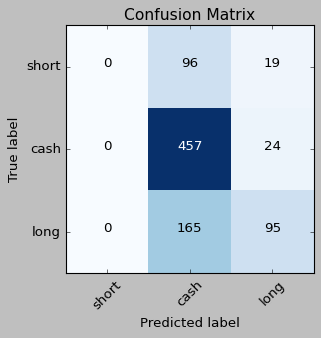

In [15]:
plt.style.use('classic')
plt.figure(figsize=(4,4))
plt.subplots_adjust(hspace = 0.1)
pretty_print_conf_matrix(y_test, prediction_test, classes= ['short', 'cash', 'long'],
                         normalize=False, title='Confusion Matrix')

# KNN Train:

In [16]:
rpt = classification_report(y_train, prediction_train, target_names = ['short', 'cash', 'long'] )
print(rpt)

              precision    recall  f1-score   support

       short       0.56      0.32      0.40       914
        cash       0.51      0.64      0.57      1258
        long       0.57      0.59      0.58      1308

    accuracy                           0.54      3480
   macro avg       0.54      0.52      0.52      3480
weighted avg       0.54      0.54      0.53      3480



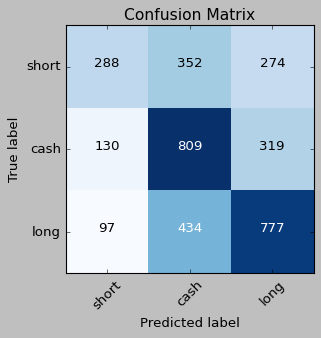

In [17]:
plt.style.use('classic')
plt.figure(figsize=(4,4))
plt.subplots_adjust(hspace = 0.1)
pretty_print_conf_matrix(y_train, prediction_train, classes= ['short', 'cash', 'long'],
                         normalize=False, title='Confusion Matrix')

# Classification for  Benchmark

In [0]:
window_size = 1
look_forward =20
train_ratio = 0.8
MAs_array = MAs.values
x_scaled, y = create_dataset_percentage_gap(MAs_array, window_size, look_forward, 1)
test_y = y[int(len(y)*train_ratio):,:]
y1, y2 = benchmark(test_y,look_forward)
y1, y2 = y_classifier(y1.reshape(-1,1), 0.02), y_classifier(y2.reshape(-1,1), 0.02)


In [19]:
rpt = classification_report(y1, y2, target_names = ['short', 'cash', 'long'] )
print(rpt)

              precision    recall  f1-score   support

       short       0.08      0.05      0.06       115
        cash       0.56      0.64      0.60       470
        long       0.07      0.07      0.07       244

    accuracy                           0.39       829
   macro avg       0.24      0.25      0.24       829
weighted avg       0.35      0.39      0.37       829



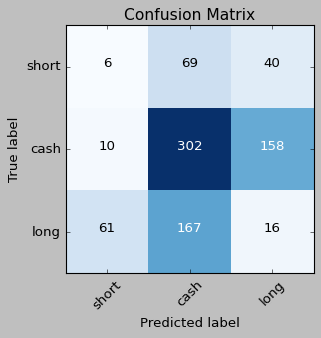

In [20]:
import itertools 
plt.style.use('classic')
plt.figure(figsize=(4,4))
plt.subplots_adjust(hspace = 0.1)
pretty_print_conf_matrix(y1, y2, classes= ['short', 'cash', 'long'],
                         normalize=False, title='Confusion Matrix')

# SVM Regressor

In [21]:
train_ratio = 0.8
batch_size = 8
kernels = ['poly']  
look_forward = 20
window_size = 1
Cs = [5]
gammas = [4]
degrees = [3]
look_forwards = [20]
K, Ct, G, D, LF = [], [], [], [], []
time_table, epoch_table, epoch_table, smape_test,smape_train, mae_train, mae_test, mse_train, mse_test, r2_train, r2_test = [], [], [], [], [], [], [], [], [], [], []

for kernel in kernels:
    for c in Cs:
        for d in degrees:
            for g in gammas:
                for look_forward in look_forwards:
                    start_time = time.time()
                    
                    scaler = MinMaxScaler(feature_range=(0.00001, 1)) 
                    MAs_scaled = scaler.fit_transform(MAs)
                    x, y_scaled = create_dataset_difference_gap(MAs_scaled, 1, look_forward,1)
                    MAs_array = MAs.values
                    x_scaled, y = create_dataset_difference_gap(MAs_array, 1, look_forward,1)
                    y = y.ravel()
                    x = x.reshape(len(x), -1)
                    x_train, y_train, x_test, y_test = test_train_split(x, y, batch_size, train_ratio)

                    model = SVR(kernel = kernel, C = c, degree = d, gamma = g)
                    model.fit(x_train, y_train)  
                    prediction_train = model.predict(x_train)
                    prediction_test = model.predict(x_test)
                    accuracy_train_smape = round(smape(prediction_train, y_train), 2)
                    accuracy_test_smape = round(smape(prediction_test, y_test), 2)
                    accuracy_train_mse = round(mse(prediction_train, y_train), 5)
                    accuracy_test_mse = round(mse(prediction_test, y_test), 5)
                    accuracy_train_r2 = round(r2_score(prediction_train, y_train), 2)
                    accuracy_test_r2 = round(r2_score(prediction_test, y_test), 2)
                    accuracy_train_mae = round(mae(prediction_train, y_train), 4)
                    accuracy_test_mae = round(mae(prediction_test, y_test), 4)
                    smape_train.append(accuracy_train_smape)
                    smape_test.append(accuracy_test_smape)
                    mse_train.append(accuracy_train_mse)
                    mse_test.append(accuracy_test_mse)
                    r2_train.append(accuracy_train_r2)
                    r2_test.append(accuracy_test_r2)
                    mae_train.append(accuracy_train_mae)
                    mae_test.append(accuracy_test_mae)
                    end_time = time.time()
                    time_table.append(round(end_time - start_time,2))
                    K.append(kernel)
                    Ct.append(c)
                    G.append(g)
                    D.append(d)
                    LF.append(look_forward)
                    print(round(end_time - start_time,2), kernel, c, g, d, look_forward)
hyper_parameters = pd.DataFrame(list(zip(K, Ct, G, D, LF, time_table, smape_train, smape_test, mae_train,
                                         mae_test, mse_train, mse_test, r2_train, r2_test)),
        columns =['kernel', 'C', 'gamma', 'degree', 'look_forward', 'time', 'smape_train', 'smape_test',
                  'mae_train', 'mae_test', 'mse_train', 'mse_test', 'r2_train', 'r2_test'])
hyper_parameters = hyper_parameters.sort_values(by=['smape_train'], ascending=True)
hyper_parameters = hyper_parameters.reset_index(drop=True)
hyper_parameters

39.42 poly 5 4 3 20


,kernel,C,gamma,degree,look_forward,time,smape_train,smape_test,mae_train,mae_test,mse_train,mse_test,r2_train,r2_test
0,poly,5,4,3,20,39.42,118.06,117.56,3.58,6.0401,25.64893,65.50767,-3.17,-3.78


In [22]:
hyper_parameters 

,kernel,C,gamma,degree,look_forward,time,smape_train,smape_test,mae_train,mae_test,mse_train,mse_test,r2_train,r2_test
0,poly,5,4,3,20,39.42,118.06,117.56,3.58,6.0401,25.64893,65.50767,-3.17,-3.78


<Figure size 640x480 with 0 Axes>

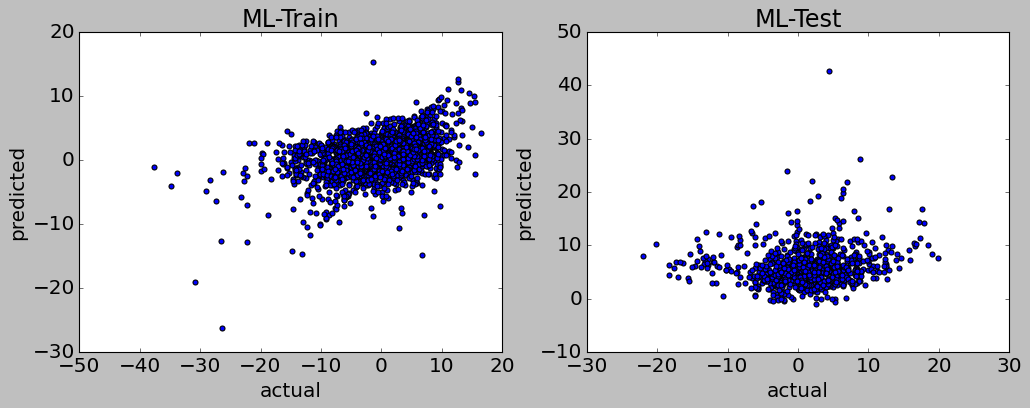

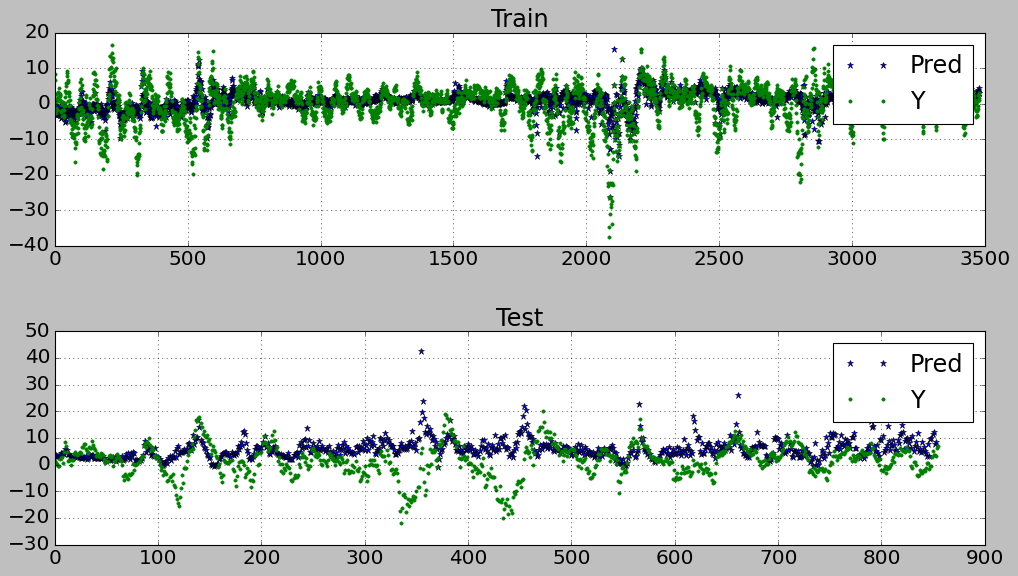

In [23]:
plot(y_train, prediction_train,y_test, prediction_test)

# SVM Classifier - has some issues

In [25]:
train_ratio = 0.8
batch_size = 8
kernels = ['poly']  
Cs = [0.35]
gammas = [3.25]
degrees = [3]
look_forwards = [20]
K, Ct, G, D, LF = [], [], [], [], []
time_table = []
long_prec ,cash_prec, short_prec, long_recal, cash_recal, short_recal, long_prec_tr =  [],[],[],[],[],[],[]
cash_prec_tr, short_prec_tr, long_recal_tr, cash_recal_tr, short_recal_tr, long_fscores =  [], [], [], [], [], []

for kernel in kernels:
    for c in Cs:
        for d in degrees:
            for g in gammas:
                for look_forward in look_forwards:
                    start_time = time.time()
                    scaler = MinMaxScaler(feature_range=(0.00001, 1)) 
                    MAs_scaled = scaler.fit_transform(MAs)
                    x, y_scaled = create_dataset_percentage_gap(MAs_scaled, 1, look_forward,1)
                    MAs_array = MAs.values
                    x_scaled, y = create_dataset_percentage_gap(MAs_array, 1, look_forward,1)
                    y = y_classifier(y, 0.02)
                    #y = y.ravel()
                    x = x.reshape(len(x), -1)
                    x_train, y_train, x_test, y_test = test_train(x, y, batch_size, train_ratio)
                    
                    model = SVC(kernel = kernel, C = c, degree = d, gamma = g)
                    model.fit(x_train, y_train)  
                    prediction_train = model.predict(x_train)
                    prediction_test = model.predict(x_test)
                    rpt = classification_report(y_test, prediction_test, target_names = ['short', 'cash', 'long'],
                                                    output_dict=True )
                    long_precision =  rpt['long']['precision']
                    long_fscore = rpt['long']['f1-score']
                    cash_precision =  rpt['cash']['precision']
                    short_precision =  rpt['short']['precision']
                    long_rec =  rpt['long']['recall']
                    cash_rec =  rpt['cash']['recall']
                    short_rec =  rpt['short']['recall']
                    rptt = classification_report(y_train, prediction_train, target_names = ['short','cash','long'], 
                                                 output_dict=True )
                    long_precision_t =  rptt['long']['precision']
                    cash_precision_t =  rptt['cash']['precision']
                    short_precision_t =  rptt['short']['precision']
                    long_rec_t =  rptt['long']['recall']
                    cash_rec_t =  rptt['cash']['recall']
                    short_rec_t =  rptt['short']['recall']
                    long_prec.append(long_precision)
                    cash_prec.append(cash_precision)
                    short_prec.append(short_precision)
                    long_recal.append(long_rec)
                    cash_recal.append(cash_rec)
                    short_recal.append(short_rec)
                    long_prec_tr.append(long_precision_t)
                    cash_prec_tr.append(cash_precision_t)
                    short_prec_tr.append(short_precision_t)
                    long_recal_tr.append(long_rec_t)
                    cash_recal_tr.append(cash_rec_t)
                    short_recal_tr.append(short_rec_t)
                    long_fscores.append(long_fscore)
                    end_time = time.time()
                    time_table.append(round(end_time - start_time,2))
                    K.append(kernel)
                    Ct.append(c)
                    G.append(g)
                    D.append(d)
                    LF.append(look_forward)
                    print(round(end_time - start_time,2), kernel, c, g, d, look_forward, long_fscore)
hyper_parameters = pd.DataFrame(list(zip(K, Ct, G, D, LF, time_table, long_fscores, long_prec, cash_prec, short_prec, long_prec_tr, 
cash_prec_tr, short_prec_tr )),
columns =['kernel', 'C', 'gamma', 'degree', 'look_forward', 'time', 'long_fscore_test', 'long_prec',
'cash_prec', 'short_prec', 'long_prec_train', 'cash_prec_train', 'short_prec_train'])
hyper_parameters = hyper_parameters.sort_values(by=['long_fscore_test'], ascending=False)
hyper_parameters = hyper_parameters.reset_index(drop=True)
hyper_parameters

NameError: ignored

In [0]:
hyper_parameters

In [0]:
rpt = classification_report(y_test, prediction_test, target_names = ['short', 'cash', 'long'] )
print(rpt)

In [0]:
plt.style.use('classic')
plt.figure(figsize=(4,4))
plt.subplots_adjust(hspace = 0.1)
pretty_print_conf_matrix(y_test, prediction_test, classes= ['short', 'cash', 'long'],
                         normalize=False, title='Confusion Matrix')

# Random Forest Regresor

In [26]:
train_ratio = 0.8
batch_size = 8
look_forward = 20
n_estimators, max_depths, min_samples_split, min_samples_leaf = [50], [100], [5], [4]
n_estimatorsl, max_depthl, min_samples_splitl, min_samples_leafl = [], [], [], []
time_table, smape_train, smape_test, mae_train, mae_test = [], [], [], [], []
mse_train, mse_test, r2_train, r2_test = [],[], [], []

for estimators in n_estimators:   
    for max_depth in max_depths:
        for min_sample_split in min_samples_split:
            for min_sample_leaf in min_samples_leaf:
                start_time = time.time()
                scaler = MinMaxScaler(feature_range=(0.00001, 1)) 
                MAs_scaled = scaler.fit_transform(MAs)
                x, y_scaled = create_dataset_percentage_gap(MAs_scaled, 1, look_forward,1)
                MAs_array = MAs.values
                x_scaled, y = create_dataset_percentage_gap(MAs_array, 1, look_forward,1)
                y = y.ravel()
                x = x.reshape(len(x), -1)
                x_train, y_train, x_test, y_test = test_train_split(x, y, batch_size, train_ratio)
                model = RandomForestRegressor(n_estimators = estimators, max_depth = max_depth,
                   min_samples_split = min_sample_split, min_samples_leaf = min_sample_leaf, random_state = 413)
                model.fit(x_train, y_train)  
                prediction_train = model.predict(x_train)
                prediction_test = model.predict(x_test)
                accuracy_train_smape = round(smape(prediction_train, y_train), 2)
                accuracy_test_smape = round(smape(prediction_test, y_test), 2)
                accuracy_train_mse = round(mse(prediction_train, y_train), 5)
                accuracy_test_mse = round(mse(prediction_test, y_test), 5)
                accuracy_train_r2 = round(r2_score(prediction_train, y_train), 2)
                accuracy_test_r2 = round(r2_score(prediction_test, y_test), 2)
                accuracy_train_mae = round(mae(prediction_train, y_train), 4)
                accuracy_test_mae = round(mae(prediction_test, y_test), 4)
                smape_train.append(accuracy_train_smape)
                smape_test.append(accuracy_test_smape)
                mse_train.append(accuracy_train_mse)
                mse_test.append(accuracy_test_mse)
                r2_train.append(accuracy_train_r2)
                r2_test.append(accuracy_test_r2)
                mae_train.append(accuracy_train_mae)
                mae_test.append(accuracy_test_mae)
                end_time = time.time()
                time_table.append(round(end_time - start_time,2))
                n_estimatorsl.append(estimators)
                max_depthl.append(max_depth)
                min_samples_splitl.append(min_sample_split)
                min_samples_leafl.append(min_sample_leaf)

                print(round(end_time - start_time,2),estimators, max_depth, min_sample_split, min_sample_leaf, 
                      accuracy_test_r2, accuracy_test_mse )
hyper_parameters = pd.DataFrame(list(zip(n_estimatorsl, max_depthl, min_samples_splitl, min_samples_leafl
                                         , time_table, smape_train, smape_test, mae_train,
                                         mae_test, mse_train, mse_test, r2_train, r2_test)),
        columns =['n_estimators',' max_depths', 'min_samples_split', 'min_samples_leaf', 'time', 'smape_train'
                  , 'smape_test','mae_train', 'mae_test', 'mse_train', 'mse_test', 'r2_train', 'r2_test'])
hyper_parameters = hyper_parameters.sort_values(by=['smape_test'], ascending=True)
hyper_parameters = hyper_parameters.reset_index(drop=True)
hyper_parameters

2.02 50 100 5 4 -4.04 0.00098


,n_estimators,max_depths,min_samples_split,min_samples_leaf,time,smape_train,smape_test,mae_train,mae_test,mse_train,mse_test,r2_train,r2_test
0,50,100,5,4,2.02,56.78,127.94,0.0126,0.0222,0.00035,0.00098,0.72,-4.04


In [27]:
hyper_parameters

,n_estimators,max_depths,min_samples_split,min_samples_leaf,time,smape_train,smape_test,mae_train,mae_test,mse_train,mse_test,r2_train,r2_test
0,50,100,5,4,2.02,56.78,127.94,0.0126,0.0222,0.00035,0.00098,0.72,-4.04


In [28]:
hyper_parameters

,n_estimators,max_depths,min_samples_split,min_samples_leaf,time,smape_train,smape_test,mae_train,mae_test,mse_train,mse_test,r2_train,r2_test
0,50,100,5,4,2.02,56.78,127.94,0.0126,0.0222,0.00035,0.00098,0.72,-4.04


<Figure size 640x480 with 0 Axes>

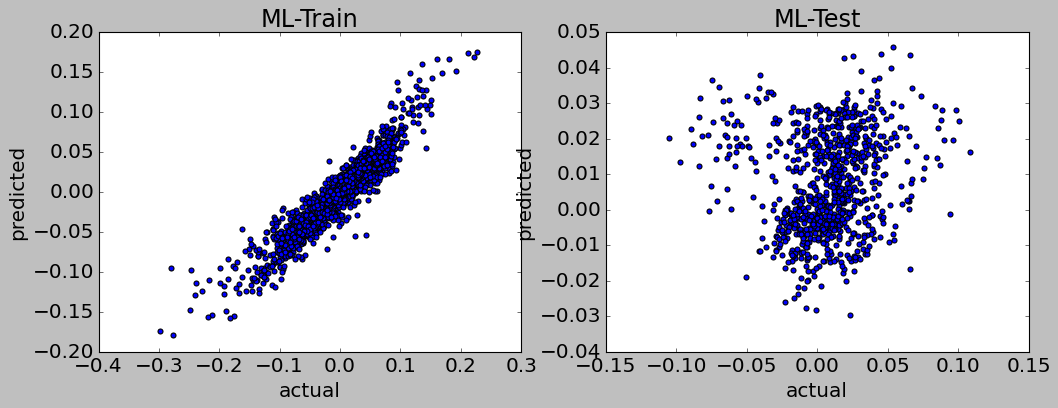

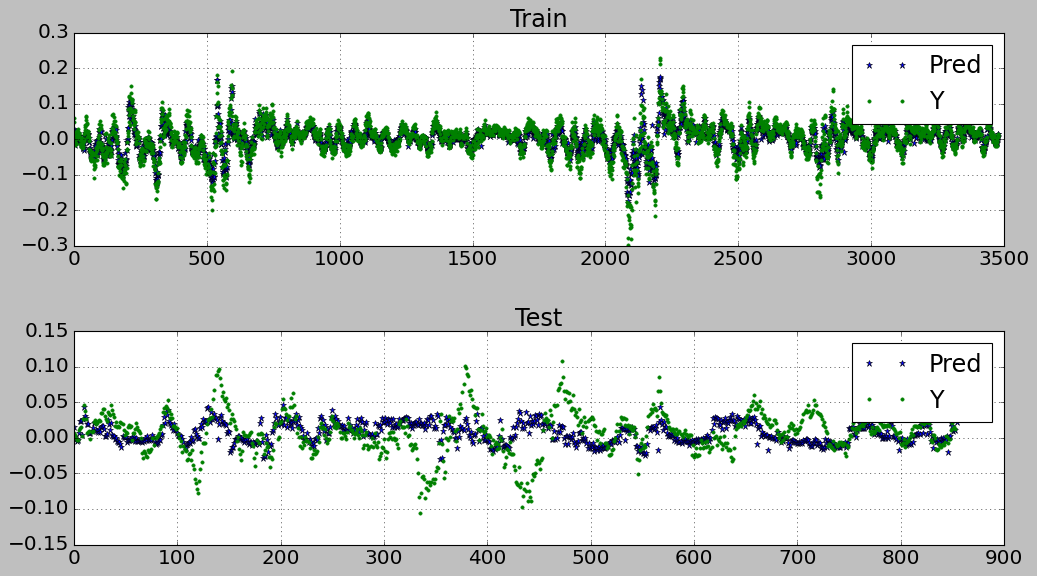

In [29]:
plot(y_train, prediction_train,y_test, prediction_test)

# Random Forest Classifier

In [30]:
train_ratio = 0.8
batch_size = 8
look_forward = 20
n_estimators, max_depths, min_samples_split, min_samples_leaf = [12], [40], [10], [4]
n_estimatorsl, max_depthl, min_samples_splitl, min_samples_leafl, long_fscores = [], [], [], [], []
long_prec ,cash_prec, short_prec, long_recal, cash_recal, short_recal, long_prec_tr =  [],[],[],[],[],[],[]
cash_prec_tr, short_prec_tr, long_recal_tr, cash_recal_tr, short_recal_tr =  [], [], [], [], []

for estimators in n_estimators:   
    for max_depth in max_depths:
        for min_sample_split in min_samples_split:
            for min_sample_leaf in min_samples_leaf:
                start_time = time.time()
                scaler = MinMaxScaler(feature_range=(0.00001, 1)) 
                MAs_scaled = scaler.fit_transform(MAs)
                x, y_scaled = create_dataset_percentage_gap(MAs_scaled, 1, look_forward,1)
                MAs_array = MAs.values
                x_scaled, y = create_dataset_percentage_gap(MAs_array, 1, look_forward,1)
                y = y_classifier(y, 0.02)
                x = x.reshape(len(x), -1)
                
                x_train, y_train, x_test, y_test = test_train_split(x, y, batch_size, train_ratio)
                model = RandomForestClassifier(n_estimators = estimators, max_depth = max_depth,
                   min_samples_split = min_sample_split, min_samples_leaf = min_sample_leaf, random_state = 413)
                model.fit(x_train, y_train)  
                prediction_train = model.predict(x_train)
                prediction_test = model.predict(x_test)
                rpt = classification_report(y_test, prediction_test, target_names = ['short', 'cash', 'long'],
                                                    output_dict=True )
                long_precision =  rpt['long']['precision']
                long_fscore = rpt['long']['f1-score']
                cash_precision =  rpt['cash']['precision']
                short_precision =  rpt['short']['precision']
                long_rec =  rpt['long']['recall']
                cash_rec =  rpt['cash']['recall']
                short_rec =  rpt['short']['recall']
                rptt = classification_report(y_train, prediction_train, target_names = ['short','cash','long'], 
                                             output_dict=True )
                long_precision_t =  rptt['long']['precision']
                cash_precision_t =  rptt['cash']['precision']
                short_precision_t =  rptt['short']['precision']
                long_rec_t =  rptt['long']['recall']
                cash_rec_t =  rptt['cash']['recall']
                short_rec_t =  rptt['short']['recall']
                long_prec.append(long_precision)
                cash_prec.append(cash_precision)
                short_prec.append(short_precision)
                long_recal.append(long_rec)
                cash_recal.append(cash_rec)
                short_recal.append(short_rec)
                long_prec_tr.append(long_precision_t)
                cash_prec_tr.append(cash_precision_t)
                short_prec_tr.append(short_precision_t)
                long_recal_tr.append(long_rec_t)
                cash_recal_tr.append(cash_rec_t)
                short_recal_tr.append(short_rec_t)
                long_fscores.append(long_fscore)
                n_estimatorsl.append(estimators)
                max_depthl.append(max_depth)
                min_samples_splitl.append(min_sample_split)
                time_table.append(round(end_time - start_time,2))
                min_samples_leafl.append(min_sample_leaf)
                print(round(end_time - start_time,2),estimators, max_depth, min_sample_split, min_sample_leaf, 
                      long_fscore)
hyper_parameters = pd.DataFrame(list(zip(n_estimatorsl, max_depthl, min_samples_splitl, min_samples_leafl
, time_table,long_fscores, long_prec, cash_prec, short_prec, long_prec_tr, cash_prec_tr, short_prec_tr  )),
columns =['n_estimators',' max_depths', 'min_samples_split', 'min_samples_leaf', 'time', 'long_fscore_test',
'long_prec','cash_prec', 'short_prec', 'long_prec_train', 'cash_prec_train', 'short_prec_train'])
hyper_parameters = hyper_parameters.sort_values(by=['long_fscore_test'], ascending=False)
hyper_parameters = hyper_parameters.reset_index(drop=True)
hyper_parameters

-1.08 12 40 10 4 0.5754716981132075


,n_estimators,max_depths,min_samples_split,min_samples_leaf,time,long_fscore_test,long_prec,cash_prec,short_prec,long_prec_train,cash_prec_train,short_prec_train
0,12,40,10,4,2.02,0.575472,0.486702,0.723356,0.102564,0.918675,0.890432,0.940421


In [31]:
hyper_parameters

,n_estimators,max_depths,min_samples_split,min_samples_leaf,time,long_fscore_test,long_prec,cash_prec,short_prec,long_prec_train,cash_prec_train,short_prec_train
0,12,40,10,4,2.02,0.575472,0.486702,0.723356,0.102564,0.918675,0.890432,0.940421


In [32]:
rpt = classification_report(y_test, prediction_test, target_names = ['short', 'cash', 'long'] )
print(rpt)

              precision    recall  f1-score   support

       short       0.10      0.03      0.05       115
        cash       0.72      0.66      0.69       481
        long       0.49      0.70      0.58       260

    accuracy                           0.59       856
   macro avg       0.44      0.47      0.44       856
weighted avg       0.57      0.59      0.57       856



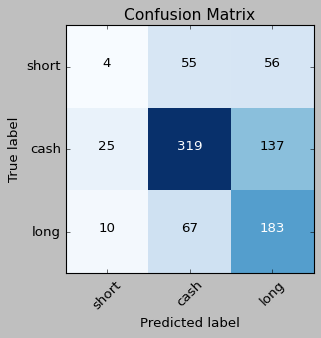

In [33]:
plt.style.use('classic')
plt.figure(figsize=(4,4))
plt.subplots_adjust(hspace = 0.1)
pretty_print_conf_matrix(y_test, prediction_test, classes= ['short', 'cash', 'long'],
                         normalize=False, title='Confusion Matrix')

# Neural Net Regressor

In [34]:
train_ratio = 0.8
window_size = 1
look_forward =20

unit_table = []
lr_table = []
batch_size_table = []
time_table, epoch_table, smape_test, smape_train, mae_train = [], [], [], [], []
mae_test, mse_train, mse_test, r2_train, r2_test = [], [], [], [], []

Units = [ 10, 20, 40]
lrs = [0.0000003, 0.00003]
batch_sizes = [32, 128]
epochs = 300
counter = 0
for units in Units:
    for lr in lrs:
        for batch_size in batch_sizes:
            total = len(Units)*len(lrs)*len(batch_sizes)
            counter += 1
            start_time = time.time()
            #fixing rnd
            fix_rnd_Keras()
            
            scaler = MinMaxScaler(feature_range=(0.00001, 1)) 
            MAs_scaled = scaler.fit_transform(MAs)
            x, y_scaled = create_dataset_percentage_gap(MAs_scaled, window_size, look_forward,1)
            MAs_array = MAs.values
            x_scaled, y = create_dataset_percentage_gap(MAs_array, window_size, look_forward,1)

            x = x.reshape(len(x), -1)
            x_train, y_train, x_test, y_test = test_train_split(x, y, batch_size, train_ratio)
            model = Sequential()
            model.add(Dense(units = units, activation = 'relu'))
            #model.add(Dropout(0.5))
            model.add(Dense(units = 1))
            opt = Adam(lr = lr)
            model.compile(loss = 'mae', optimizer = opt)
            history = model.fit(x_train, y_train, validation_data=(x_test, y_test), 
                                epochs = epochs, batch_size = batch_size, verbose = 0, shuffle=False)

            print(counter, 'out of ', total, 'units = ', units, 'lr = ', lr, 
                  'batch_size = ', batch_size, 'epoch = ', epochs)

            unit_table.append(units)
            lr_table.append(lr)
            batch_size_table.append(batch_size)
            
            prediction_train = model.predict(x_train, batch_size=batch_size)
            prediction_test = model.predict(x_test, batch_size=batch_size)
            accuracy_train_smape = round(smape(prediction_train, y_train), 2)
            accuracy_test_smape = round(smape(prediction_test, y_test), 2)
            accuracy_train_mse = round(mse(prediction_train, y_train), 5)
            accuracy_test_mse = round(mse(prediction_test, y_test), 5)
            accuracy_train_r2 = round(r2_score(prediction_train, y_train), 2)
            accuracy_test_r2 = round(r2_score(prediction_test, y_test), 2)
            accuracy_train_mae = round(mae(prediction_train, y_train), 4)
            accuracy_test_mae = round(mae(prediction_test, y_test), 4)
            smape_train.append(accuracy_train_smape)
            smape_test.append(accuracy_test_smape)
            mse_train.append(accuracy_train_mse)
            mse_test.append(accuracy_test_mse)
            r2_train.append(accuracy_train_r2)
            r2_test.append(accuracy_test_r2)
            mae_train.append(accuracy_train_mae)
            mae_test.append(accuracy_test_mae)
            end_time = time.time()
            time_table.append(round(end_time - start_time,2))
            print(accuracy_train_mae, accuracy_test_mae, (round(end_time - start_time,2)))
            pyplot.title('Loss / Mean Squared Error')
            pyplot.plot(history.history['loss'], label='train')
            pyplot.plot(history.history['val_loss'], label='test')
            pyplot.legend()
            pyplot.show()
                    
hyper_parameters = pd.DataFrame(list(zip(unit_table,lr_table,batch_size_table,
    time_table, smape_train, smape_test, mae_train, mae_test, mse_train, mse_test, r2_train, r2_test)),
        columns =['unit','lr','batch_size','time','smape_train', 'smape_test',
                  'mae_train', 'mae_test', 'mse_train', 'mse_test', 'r2_train', 'r2_test'])
hyper_parameters = hyper_parameters.sort_values(by=['smape_test'], ascending=True)
hyper_parameters = hyper_parameters.reset_index(drop=True)
hyper_parameters

AttributeError: ignored

In [0]:
hyper_parameters

In [0]:
hyper_parameters

In [0]:
plot(y_train, prediction_train,y_test, prediction_test) # 1 layer, 20 units, drop out, 2000 epochs

# Neural Net Classifier

In [0]:
train_ratio = 0.8
window_size = 1
look_forward =20

unit_table = []
lr_table = []
batch_size_table = []
time_table, epoch_table = [], []
long_prec ,cash_prec, short_prec, long_recal, cash_recal, short_recal, long_prec_tr =  [],[],[],[],[],[],[]
cash_prec_tr, short_prec_tr, long_recal_tr, cash_recal_tr, short_recal_tr, long_fscores =  [], [], [], [], [], []

Units = [40]
lrs = [ 0.00003]
batch_sizes = [256]
epoch = [6000]
counter = 0
for units in Units:
    for lr in lrs:
        for batch_size in batch_sizes:
            for epochs in epoch:
                total = len(Units)*len(lrs)*len(batch_sizes)* len(epoch)
                counter += 1
                start_time = time.time()
                #fixing rnd
                fix_rnd_Keras()

                scaler = MinMaxScaler(feature_range=(0.00001, 1)) 
                MAs_scaled = scaler.fit_transform(MAs)
                x, y_scaled = create_dataset_percentage_gap(MAs_scaled, window_size, look_forward,1)
                MAs_array = MAs.values
                x_scaled, y = create_dataset_percentage_gap(MAs_array, window_size, look_forward,1)
                y = y_classifier(y, 0.02)
                y = y_softmax(y)
                x = x.reshape(len(x), -1)
                x_train, y_train, x_test, y_test = test_train_split(x, y, batch_size, train_ratio)

                model = Sequential()
                model.add(Dense(units = units, activation = 'relu'))
                model.add(Dropout(0.5))
                model.add(Dense(units = units, activation = 'relu'))
                model.add(Dropout(0.5))
                model.add(Dense(3, activation='softmax'))
                opt = Adam(lr = lr)
                model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
                history = model.fit(x_train, y_train, validation_data=(x_test, y_test), 
                                    epochs = epochs, batch_size = batch_size, verbose = 0, shuffle=False)

                pyplot.plot(history.history['loss'], label='train')
                pyplot.plot(history.history['val_loss'], label='test')
                pyplot.legend()
                pyplot.show()
                unit_table.append(units)
                lr_table.append(lr)
                batch_size_table.append(batch_size)
                prediction_train = model.predict(x_train)
                prediction_test = model.predict(x_test)
                y_train, y_test, prediction_train, prediction_test = desoftmaxer(y_train), desoftmaxer(y_test),desoftmaxer(prediction_train), desoftmaxer(prediction_test)
                rpt = classification_report(y_test, prediction_test, target_names = ['short', 'cash', 'long'],
                                            output_dict=True )
                long_precision =  rpt['long']['precision']
                long_fscore = rpt['long']['f1-score']
                cash_precision =  rpt['cash']['precision']
                short_precision =  rpt['short']['precision']
                long_rec =  rpt['long']['recall']
                cash_rec =  rpt['cash']['recall']
                short_rec =  rpt['short']['recall']
                rptt = classification_report(y_train, prediction_train, target_names = ['short', 'cash', 'long'], 
                                             output_dict=True )
                long_precision_t =  rptt['long']['precision']
                cash_precision_t =  rptt['cash']['precision']
                short_precision_t =  rptt['short']['precision']
                long_rec_t =  rptt['long']['recall']
                cash_rec_t =  rptt['cash']['recall']
                short_rec_t =  rptt['short']['recall']
                long_prec.append(long_precision)
                cash_prec.append(cash_precision)
                short_prec.append(short_precision)
                long_recal.append(long_rec)
                cash_recal.append(cash_rec)
                short_recal.append(short_rec)
                long_prec_tr.append(long_precision_t)
                cash_prec_tr.append(cash_precision_t)
                short_prec_tr.append(short_precision_t)
                long_recal_tr.append(long_rec_t)
                cash_recal_tr.append(cash_rec_t)
                short_recal_tr.append(short_rec_t)
                long_fscores.append(long_fscore)
                epoch_table.append(epochs)

                end_time = time.time()
                time_table.append(round(end_time - start_time,2))
                print(round(end_time - start_time,2), counter, 'out of ', total, 'units = ', units, 'lr = ', lr, 
    'batch_size = ', batch_size, 'epoch = ', epochs,'long prec = ', long_precision, 'fscore = ', long_fscore)
            
hyper_parameters = pd.DataFrame(list(zip(unit_table, epoch_table, lr_table, batch_size_table, time_table, long_fscores, long_prec, 
            cash_prec, short_prec, long_prec_tr, cash_prec_tr, short_prec_tr )),
            columns =['unit', 'epoch', 'lr', 'batch', 'time', 'long_fscore_test', 'long_prec',
'cash_prec', 'short_prec', 'long_prec_train', 'cash_prec_train', 'short_prec_train'])
hyper_parameters = hyper_parameters.sort_values(by=['long_fscore_test'], ascending=False)
hyper_parameters = hyper_parameters.reset_index(drop=True)
hyper_parameters


In [0]:
plt.style.use('classic')
plt.figure(figsize=(4,4))
plt.subplots_adjust(hspace = 0.1)
pretty_print_conf_matrix(y_test,prediction_test, classes= ['short', 'cash', 'long'],
normalize=False, title='Confusion Matrix')

In [0]:
rpt = classification_report(y_test, prediction_test, target_names = ['short', 'cash', 'long'])
print(rpt)

# Train confusion

In [0]:
plt.style.use('classic')
plt.figure(figsize=(4,4))
plt.subplots_adjust(hspace = 0.1)
pretty_print_conf_matrix(y_train,prediction_train, classes= ['short', 'cash', 'long'],
normalize=False, title='Confusion Matrix')

In [0]:
rpt = classification_report(y_train, prediction_train, target_names = ['short', 'cash', 'long'])
print(rpt)

# LSTM Regressor

In [35]:
train_ratio = 0.8

unit_table = []
lr_table = []
batch_size_table = []

unit_table = []
lr_table = []
batch_size_table = []
time_table, epoch_table, smape_test, smape_train, mae_train, window_size_table = [], [], [], [], [], []
mae_test, mse_train, mse_test, r2_train, r2_test = [], [], [], [], []

Units = [ 10]
lrs = [ 0.0000006]
look_forwards = [20]
window_sizes = [20]
batch_sizes = [32]
Epochs = [80]
counter = 0
for units in Units:
    for lr in lrs:
        for look_forward in look_forwards:
            for window_size in window_sizes:
                for batch_size in batch_sizes:
                    for epochs in Epochs:
                        total = len(Units)*len(lrs)*len(look_forwards)*len(window_sizes)*len(batch_sizes)
                        counter += 1
                        start_time = time.time()
                        
                        fix_rnd_Keras()
                        scaler = MinMaxScaler(feature_range=(0.00001, 1)) 
                        MAs_scaled = scaler.fit_transform(MAs)
                        x, y_scaled = create_dataset_percentage_gap(MAs_scaled, window_size, look_forward,1)
                        MAs_array = MAs.values
                        x_scaled, y = create_dataset_percentage_gap(MAs_array, window_size, look_forward,1)

                        train_length = int(len(x)*train_ratio)

                        for i in range(train_length, train_length+batch_size):
                            remainder = i%batch_size
                            if remainder == 0:
                                train_length = i
                                break
                        x_train = x[:train_length,:]
                        y_train = y[:train_length,:]

                        for i in range(len(x)-batch_size, len(x)):
                            remainder = i%batch_size
                            if remainder == 0:
                                train_length_test = i
                                break
                        x_test = x[train_length:train_length_test,:]
                        y_test = y[train_length:train_length_test,:]

                        model = Sequential()
                        model.add(LSTM(units = units, batch_input_shape=(batch_size, window_size, x_train.shape[2]), 
                        stateful=True))#, return_sequences = True))
                        #model.add(LSTM(units = units, batch_input_shape=(batch_size, window_size, x_train.shape[2])
                        #,stateful=True))

                        model.add(Dense(units = 1))
                        opt = Adam(lr = lr)
                        model.compile(loss = 'mae', optimizer = opt)
                        history = model.fit(x_train, y_train, validation_data=(x_test, y_test), 
                                            epochs = epochs, batch_size = batch_size, verbose = 0, shuffle=False)

                        print(counter, 'out of ', total, 'units = ', units, 'lr = ', lr, 'look_forward =', look_forward,
                              'window_size =', window_size, 'batch_size = ', batch_size, 'epoch = ', epochs)

                        unit_table.append(units)
                        lr_table.append(lr)
                        window_size_table.append(window_size)
                        batch_size_table.append(batch_size)
                        epoch_table.append(epochs)

                        prediction_train = model.predict(x_train, batch_size=batch_size)
                        prediction_test = model.predict(x_test, batch_size=batch_size)
                        accuracy_train_smape = round(smape(prediction_train, y_train), 2)
                        accuracy_test_smape = round(smape(prediction_test, y_test), 2)
                        accuracy_train_mse = round(mse(prediction_train, y_train), 5)
                        accuracy_test_mse = round(mse(prediction_test, y_test), 5)
                        accuracy_train_r2 = round(r2_score(prediction_train, y_train), 2)
                        accuracy_test_r2 = round(r2_score(prediction_test, y_test), 2)
                        accuracy_train_mae = round(mae(prediction_train, y_train), 4)
                        accuracy_test_mae = round(mae(prediction_test, y_test), 4)
                        smape_train.append(accuracy_train_smape)
                        smape_test.append(accuracy_test_smape)
                        mse_train.append(accuracy_train_mse)
                        mse_test.append(accuracy_test_mse)
                        r2_train.append(accuracy_train_r2)
                        r2_test.append(accuracy_test_r2)
                        mae_train.append(accuracy_train_mae)
                        mae_test.append(accuracy_test_mae)
                        end_time = time.time()
                        time_table.append(round(end_time - start_time,2))
                        print(accuracy_train_mae, accuracy_test_mae, (round(end_time - start_time,2)))
                        pyplot.title('Loss / Mean Squared Error')
                        pyplot.plot(history.history['loss'], label='train')
                        pyplot.plot(history.history['val_loss'], label='test')
                        pyplot.legend()
                        pyplot.show()
                    
hyper_parameters = pd.DataFrame(list(zip(unit_table,lr_table,window_size_table,batch_size_table,
    time_table, epoch_table, smape_train, smape_test, mae_train, mae_test, mse_train, mse_test, r2_train, r2_test)),
        columns =['unit','lr','window_size','batch_size','time', 'epoch', 'smape_train', 'smape_test',
                  'mae_train', 'mae_test', 'mse_train', 'mse_test', 'r2_train', 'r2_test'])
hyper_parameters = hyper_parameters.sort_values(by=['smape_train'], ascending=True)
hyper_parameters = hyper_parameters.reset_index(drop=True)
hyper_parameters

AttributeError: ignored

<Figure size 640x480 with 0 Axes>

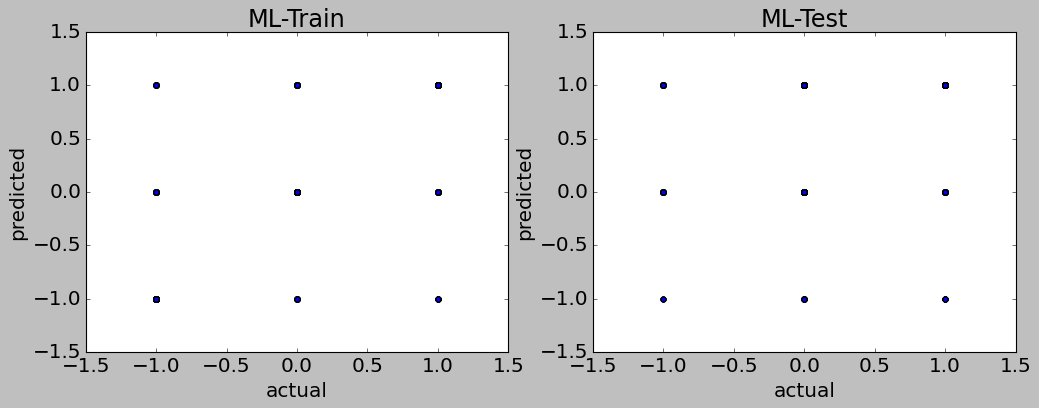

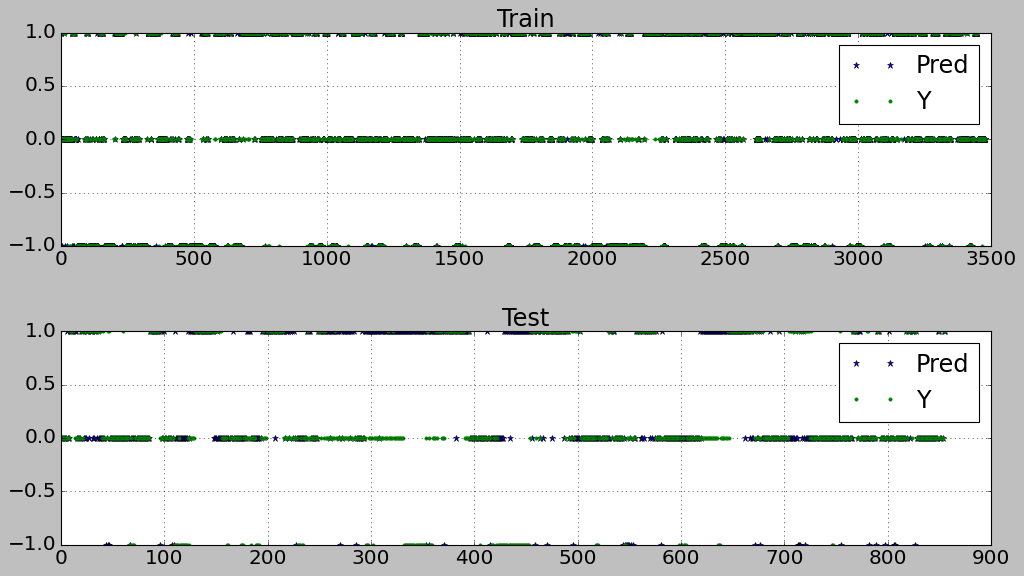

In [36]:
plot(y_train, prediction_train,y_test, prediction_test)

# LSTM Classify

In [0]:
train_ratio = 0.8
window_size = 10
look_forward =20

unit_table = []
lr_table = []
batch_size_table = []
time_table, epoch_table = [], []
long_prec ,cash_prec, short_prec, long_recal, cash_recal, short_recal, long_prec_trf =  [],[],[],[],[],[],[]
cash_prec_tr, short_prec_tr, long_recal_tr, cash_recal_tr, short_recal_tr, long_fscores =  [], [], [], [], [], []

Units = [10]
lrs = [ 0.0001]
batch_sizes = [256]
epoch = [110]
counter = 0
for units in Units:
    for lr in lrs:
        for batch_size in batch_sizes:
            for epochs in epoch:
                total = len(Units)*len(lrs)*len(batch_sizes)* len(epoch)
                counter += 1
                start_time = time.time()
                #fixing rnd
                fix_rnd_Keras()

                scaler = MinMaxScaler(feature_range=(0.00001, 1)) 
                MAs_scaled = scaler.fit_transform(MAs)
                x, y_scaled = create_dataset_percentage_gap(MAs_scaled, window_size, look_forward,1)
                MAs_array = MAs.values
                x_scaled, y = create_dataset_percentage_gap(MAs_array, window_size, look_forward,1)
                y = y_classifier(y, 0.02)
                y = y_softmax(y)

                train_length = int(len(x)*train_ratio)

                for i in range(train_length, train_length+batch_size):
                    remainder = i%batch_size
                    if remainder == 0:
                        train_length = i
                        break
                x_train = x[:train_length,:]
                y_train = y[:train_length,]

                for i in range(len(x)-batch_size, len(x)):
                    remainder = i%batch_size
                    if remainder == 0:
                        train_length_test = i
                        break
                x_test = x[train_length:train_length_test,:]
                y_test = y[train_length:train_length_test,]

                model = Sequential()
                model.add(LSTM(units = units, batch_input_shape=(batch_size, window_size, x_train.shape[2]),
                               stateful=True))#, return_sequences = True))
                #model.add(LSTM(units = units, batch_input_shape=(batch_size, window_size, x_train.shape[2])
                #,stateful=True))
                model.add(Dense(3, activation='softmax'))
                opt = Adam(lr = lr)
                model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
                history = model.fit(x_train, y_train, validation_data=(x_test, y_test), 
                                    epochs = epochs, batch_size = batch_size, verbose = 0, shuffle=False)

                pyplot.plot(history.history['loss'], label='train')
                pyplot.plot(history.history['val_loss'], label='test')
                pyplot.legend()
                pyplot.show()
                unit_table.append(units)
                lr_table.append(lr)
                batch_size_table.append(batch_size)
                prediction_train = model.predict(x_train, batch_size=batch_size)
                prediction_test = model.predict(x_test, batch_size=batch_size)
                y_train, y_test, prediction_train, prediction_test = desoftmaxer(y_train), desoftmaxer(y_test),desoftmaxer(prediction_train), desoftmaxer(prediction_test)
                rpt = classification_report(y_test, prediction_test, target_names = ['short', 'cash', 'long'],
                                            output_dict=True )
                long_precision =  rpt['long']['precision']
                long_fscore = rpt['long']['f1-score']
                cash_precision =  rpt['cash']['precision']
                short_precision =  rpt['short']['precision']
                long_rec =  rpt['long']['recall']
                cash_rec =  rpt['cash']['recall']
                short_rec =  rpt['short']['recall']
                rptt = classification_report(y_train, prediction_train, target_names = ['short', 'cash', 'long'], 
                                             output_dict=True )
                longf_precision_t =  rptt['long']['f1-score']
                cash_precision_t =  rptt['cash']['precision']
                short_precision_t =  rptt['short']['precision']
                long_rec_t =  rptt['long']['recall']
                cash_rec_t =  rptt['cash']['recall']
                short_rec_t =  rptt['short']['recall']
                long_prec.append(long_precision)
                cash_prec.append(cash_precision)
                short_prec.append(short_precision)
                long_recal.append(long_rec)
                cash_recal.append(cash_rec)
                short_recal.append(short_rec)
                long_prec_trf.append(longf_precision_t)
                cash_prec_tr.append(cash_precision_t)
                short_prec_tr.append(short_precision_t)
                long_recal_tr.append(long_rec_t)
                cash_recal_tr.append(cash_rec_t)
                short_recal_tr.append(short_rec_t)
                long_fscores.append(long_fscore)
                epoch_table.append(epochs)

                end_time = time.time()
                time_table.append(round(end_time - start_time,2))
                print(round(end_time - start_time,2), counter, 'out of ', total, 'units = ', units, 'lr = ', lr, 
    'batch_size = ', batch_size, 'epoch = ', epochs,'long prec = ', long_precision, 'fscore = ', long_fscore)
            
hyper_parameters = pd.DataFrame(list(zip(unit_table, epoch_table, lr_table, batch_size_table, time_table, long_fscores, long_prec, 
            cash_prec, short_prec, long_prec_trf, cash_prec_tr, short_prec_tr )),
            columns =['unit', 'epoch', 'lr', 'batch', 'time', 'long_fscore_test', 'long_prec',
'cash_prec', 'short_prec', 'fscore_train', 'cash_prec_train', 'short_prec_train'])
hyper_parameters = hyper_parameters.sort_values(by=['long_fscore_test'], ascending=False)
hyper_parameters = hyper_parameters.reset_index(drop=True)
hyper_parameters


In [0]:
plt.style.use('classic')
plt.figure(figsize=(4,4))
plt.subplots_adjust(hspace = 0.1)
pretty_print_conf_matrix(y_test,prediction_test, classes= ['short', 'cash', 'long'],
normalize=False, title='Confusion Matrix')
rpt = classification_report(y_test, prediction_test, target_names = ['short', 'cash', 'long'])
print(rpt)

# CNN REgressor

In [0]:
train_ratio = 0.8
window_size = 40
look_forward =20

unit_table = []
lr_table = []
look_forward_table = []
window_size_table = []
batch_size_table = []
filter_table, kernel_size_table = [], []
time_table = []
epoch_table = []
smape_train = []
smape_test = []
mae_train = [] 
mae_test = [] 
mse_train = [] 
mse_test = [] 
r2_train =[]
r2_test = []

Units = [ 160]
lrs = [ 0.00003]
batch_sizes = [64]
epoch = [100]
Filters = [10]
kernel_sizes = [5]

counter = 0
for units in Units:
    for lr in lrs:
        for batch_size in batch_sizes:
            for epochs in epoch:
                for kernel_size in kernel_sizes:
                    for filters in Filters:
                        total = len(Units)*len(lrs)*len(batch_sizes)*len(epoch)*len(kernel_sizes)*len(Filters)
                        counter += 1
                        start_time = time.time()
                        #fixing rnd
                        fix_rnd_Keras()

                        scaler = MinMaxScaler(feature_range=(0.00001, 1)) 
                        MAs_scaled = scaler.fit_transform(MAs)
                        x, y_scaled = create_dataset_percentage_gap(MAs_scaled, window_size, look_forward,1)
                        MAs_array = MAs.values
                        x_scaled, y = create_dataset_percentage_gap(MAs_array, window_size, look_forward,1)

                        #just for dense ANN, remove this for lstm
                        #x = x.reshape(len(x), -1)
                        train_length = int(len(x)*train_ratio)

                        for i in range(train_length, train_length+batch_size):
                            remainder = i%batch_size
                            if remainder == 0:
                                train_length = i
                                break
                        x_train = x[:train_length,:]
                        y_train = y[:train_length,:]

                        for i in range(len(x)-batch_size, len(x)):
                            remainder = i%batch_size
                            if remainder == 0:
                                train_length_test = i
                                break
                        x_test = x[train_length:train_length_test,:]
                        y_test = y[train_length:train_length_test,:]

                        model = Sequential()
                        model.add(Conv1D(filters = filters, kernel_size = kernel_size, activation = 'relu',
                                         input_shape = (window_size, x_train.shape[2])))
                        model.add(Conv1D(filters = filters, kernel_size = kernel_size, activation = 'relu'))
                        model.add(MaxPooling1D(pool_size = 3))
                        model.add(Flatten())
                        model.add(Dense(units = units, activation='relu'))
                        model.add(Dense(units = 1))
                        opt = Adam(lr = lr)
                        model.compile(loss = 'mae', optimizer = opt)
                        history = model.fit(x_train, y_train, validation_data=(x_test, y_test), 
                                            epochs = epochs, verbose = 0, shuffle=False)

                        print(counter, 'out of ', total, 'filters = ', filters, 'units = ', units, 'lr = ', lr, 
                              'batch_size = ', batch_size, 'epoch = ', epochs)

                        unit_table.append(units)
                        lr_table.append(lr)
                        batch_size_table.append(batch_size)

                        prediction_train = model.predict(x_train)
                        prediction_test = model.predict(x_test)
                        accuracy_train_smape = round(smape(prediction_train, y_train), 2)
                        accuracy_test_smape = round(smape(prediction_test, y_test), 2)
                        accuracy_train_mse = round(mse(prediction_train, y_train), 5)
                        accuracy_test_mse = round(mse(prediction_test, y_test), 5)
                        accuracy_train_r2 = round(r2_score(prediction_train, y_train), 2)
                        accuracy_test_r2 = round(r2_score(prediction_test, y_test), 2)
                        accuracy_train_mae = round(mae(prediction_train, y_train), 4)
                        accuracy_test_mae = round(mae(prediction_test, y_test), 4)
                        smape_train.append(accuracy_train_smape)
                        smape_test.append(accuracy_test_smape)
                        mse_train.append(accuracy_train_mse)
                        mse_test.append(accuracy_test_mse)
                        r2_train.append(accuracy_train_r2)
                        r2_test.append(accuracy_test_r2)
                        mae_train.append(accuracy_train_mae)
                        mae_test.append(accuracy_test_mae)
                        filter_table.append(filters)
                        kernel_size_table.append(kernel_size)
                        end_time = time.time()
                        time_table.append(round(end_time - start_time,2))
                        print(accuracy_train_mae, accuracy_test_mae, (round(end_time - start_time,2)))
                        pyplot.title('Loss / Mean Squared Error')
                        pyplot.plot(history.history['loss'], label='train')
                        pyplot.plot(history.history['val_loss'], label='test')
                        pyplot.legend()
                        pyplot.show()

hyper_parameters = pd.DataFrame(list(zip(filter_table, kernel_size_table, unit_table,lr_table,batch_size_table,
    time_table, smape_train, smape_test, mae_train, mae_test, mse_train, mse_test, r2_train, r2_test)),
        columns =['filter', 'kernel', 'unit','lr','batch_size','time','smape_train', 'smape_test',
                  'mae_train', 'mae_test', 'mse_train', 'mse_test', 'r2_train', 'r2_test'])
hyper_parameters = hyper_parameters.sort_values(by=['smape_test'], ascending=True)
hyper_parameters = hyper_parameters.reset_index(drop=True)
model.summary()
hyper_parameters

In [0]:
hyper_parameters

In [0]:
hyper_parameters

In [0]:
hyper_parameters

In [0]:
hyper_parameters

In [0]:
hyper_parameters = hyper_parameters.sort_values(by=['mae_test'], ascending=True)
hyper_parameters = hyper_parameters.reset_index(drop=True)
hyper_parameters

In [0]:
fig = plt.figure()
plt.rcParams.update({'font.size': 18})
plt.subplots_adjust(hspace = 0.4)
plt.figure(figsize=(16,16))
plt.subplot(3, 2, 1)
plt.scatter(y1,y2)
plt.ylabel('auto correlated value')
plt.xlabel('real change')
plt.title('Autocorrelation-Test')
plt.subplots_adjust(hspace = 0.4)

plt.subplot(3, 2, 2)
plt.scatter(y_test, prediction_test)
plt.ylabel('predicted')
plt.xlabel('actual')
plt.title('ML-Test')
plt.axis([-0.15, 0.15, -0.15, 0.15])

plt.subplot(3, 2, 3)
plt.scatter(y_train, prediction_train)
plt.ylabel('predicted')
plt.xlabel('actual')
plt.title('ML-Train')

plt.subplot(3, 2, 4)
plt.plot(prediction_train, marker = '*',linestyle="None", label = 'Pred')
plt.plot(y_train, marker = '.', label = 'Y', linestyle="None")
plt.grid()
plt.legend()
plt.title('Train')

plt.subplot(3, 2, 5)
plt.plot(y2, marker = '*',linestyle="None", label = 'Pred')
plt.plot(y1, marker = '.', label = 'Y', linestyle="None")
plt.grid()
plt.legend()
plt.title('Autocorrelation vs y')

plt.subplot(3, 2, 6)
plt.plot(prediction_test, marker = '*', label = 'Pred',linestyle="None")
plt.plot(y_test, marker = '.',linestyle="None" , label = 'Y')
plt.grid()
plt.legend()
plt.title('Test')
plt.axis([0, 900, -0.1, 0.1])

# CNN Classifier

In [0]:
train_ratio = 0.8
window_size = 20
look_forward =20

unit_table = []
lr_table = []
look_forward_table = []
window_size_table = []
batch_size_table = []
filter_table, kernel_size_table = [], []
time_table = []
epoch_table = []
long_prec ,cash_prec, short_prec, long_recal, cash_recal, short_recal, long_prec_tr =  [],[],[],[],[],[],[]
cash_prec_tr, short_prec_tr, long_recal_tr, cash_recal_tr, short_recal_tr, long_fscores =  [], [], [], [], [], []



Units = [40]
lrs = [ 0.00009]
batch_sizes = [ 256]
epoch = [120]
Filters = [24]
kernel_sizes = [8]

counter = 0
for units in Units:
    for lr in lrs:
        for batch_size in batch_sizes:
            for epochs in epoch:
                for kernel_size in kernel_sizes:
                    for filters in Filters:
                        total = len(Units)*len(lrs)*len(batch_sizes)*len(epoch)*len(kernel_sizes)*len(Filters)
                        counter += 1
                        start_time = time.time()
                        #fixing rnd
                        fix_rnd_Keras()

                        scaler = MinMaxScaler(feature_range=(0.00001, 1)) 
                        MAs_scaled = scaler.fit_transform(MAs)
                        x, y_scaled = create_dataset_percentage_gap(MAs_scaled, window_size, look_forward,1)
                        MAs_array = MAs.values
                        x_scaled, y = create_dataset_percentage_gap(MAs_array, window_size, look_forward,1)
                        y = y_classifier(y, 0.02)
                        y = y_softmax(y)
                        #just for dense ANN, remove this for lstm
                        #x = x.reshape(len(x), -1)
                        train_length = int(len(x)*train_ratio)

                        for i in range(train_length, train_length+batch_size):
                            remainder = i%batch_size
                            if remainder == 0:
                                train_length = i
                                break
                        x_train = x[:train_length,:]
                        y_train = y[:train_length,:]

                        for i in range(len(x)-batch_size, len(x)):
                            remainder = i%batch_size
                            if remainder == 0:
                                train_length_test = i
                                break
                        x_test = x[train_length:train_length_test,:]
                        y_test = y[train_length:train_length_test,:]

                        model = Sequential()
                        model.add(Conv1D(filters = filters, kernel_size = kernel_size, activation = 'relu',
                                         input_shape = (window_size, x_train.shape[2])))
                        model.add(Dropout(0.5))
                        #model.add(MaxPooling1D(pool_size = 3))
                        model.add(Flatten())
                        model.add(Dense(units = units, activation='relu'))
                        model.add(Dropout(0.5))
                        model.add(Dense(units = units, activation='relu'))
                        model.add(Dropout(0.5))

                        model.add(Dense(3, activation='softmax'))
                        opt = Adam(lr = lr)
                        model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
                        history = model.fit(x_train, y_train, validation_data=(x_test, y_test), 
                                            epochs = epochs, verbose = 0, shuffle=False)

                        pyplot.plot(history.history['loss'], label='train')
                        pyplot.plot(history.history['val_loss'], label='test')
                        pyplot.legend()
                        pyplot.show()
                        unit_table.append(units)
                        lr_table.append(lr)
                        batch_size_table.append(batch_size)
                        prediction_train = model.predict(x_train, batch_size=batch_size)
                        prediction_test = model.predict(x_test, batch_size=batch_size)
                        y_train, y_test, prediction_train, prediction_test = desoftmaxer(y_train), desoftmaxer(y_test),desoftmaxer(prediction_train), desoftmaxer(prediction_test)
                        rpt = classification_report(y_test, prediction_test, target_names = ['short', 'cash', 'long'],
                                                    output_dict=True )
                        long_precision =  rpt['long']['precision']
                        long_fscore = rpt['long']['f1-score']
                        cash_precision =  rpt['cash']['precision']
                        short_precision =  rpt['short']['precision']
                        long_rec =  rpt['long']['recall']
                        cash_rec =  rpt['cash']['recall']
                        short_rec =  rpt['short']['recall']
                        rptt = classification_report(y_train, prediction_train, target_names = ['short','cash','long'], 
                                                     output_dict=True )
                        long_precision_t =  rptt['long']['precision']
                        cash_precision_t =  rptt['cash']['precision']
                        short_precision_t =  rptt['short']['precision']
                        long_rec_t =  rptt['long']['recall']
                        cash_rec_t =  rptt['cash']['recall']
                        short_rec_t =  rptt['short']['recall']
                        long_prec.append(long_precision)
                        cash_prec.append(cash_precision)
                        short_prec.append(short_precision)
                        long_recal.append(long_rec)
                        cash_recal.append(cash_rec)
                        short_recal.append(short_rec)
                        long_prec_tr.append(long_precision_t)
                        cash_prec_tr.append(cash_precision_t)
                        short_prec_tr.append(short_precision_t)
                        long_recal_tr.append(long_rec_t)
                        cash_recal_tr.append(cash_rec_t)
                        short_recal_tr.append(short_rec_t)
                        long_fscores.append(long_fscore)
                        epoch_table.append(epochs)
                        filter_table.append(filters)
                        kernel_size_table.append(kernel_size)

                        end_time = time.time()
                        time_table.append(round(end_time - start_time,2))
                        print(round(end_time - start_time,2), 'filters =', filters, 'kernel =', kernel_size, counter, 'out of ', total, 'units = ', units, 'lr = ', 
lr, 'batch_size = ', batch_size, 'epoch = ', epochs,'long prec = ', long_precision, 'fscore = ', long_fscore)
            
hyper_parameters = pd.DataFrame(list(zip( kernel_size_table,filter_table, unit_table, epoch_table, lr_table, batch_size_table, time_table,
                                         long_fscores, long_prec, 
            cash_prec, short_prec, long_prec_tr, cash_prec_tr, short_prec_tr )),
            columns =['kernel_size', 'filters','unit', 'epoch', 'lr', 'batch', 'time', 'long_fscore_test', 'long_prec',
'cash_prec', 'short_prec', 'long_prec_train', 'cash_prec_train', 'short_prec_train'])
hyper_parameters = hyper_parameters.sort_values(by=['long_fscore_test'], ascending=False)
hyper_parameters = hyper_parameters.reset_index(drop=True)
model.summary()
hyper_parameters

In [0]:
plt.style.use('classic')
plt.figure(figsize=(4,4))
plt.subplots_adjust(hspace = 0.1)
pretty_print_conf_matrix(y_test,prediction_test, classes= ['short', 'cash', 'long'],
normalize=False, title='Confusion Matrix')

In [0]:
rpt = classification_report(y_test, prediction_test, target_names = ['short', 'cash', 'long'])
print(rpt)

In [0]:
hyper_parameters # window 20

In [0]:
hyper_parameters

In [0]:
hyper_parameters

In [0]:
hyper_parameters

# XGBoost Regressor

In [0]:
train_ratio = 0.8
window_size = 1
look_forward =20
batch_size = 16
seed_value= 0
lrs_t, cols_t, ns_t, depths_t, subs_t, gamma_t = [], [], [], [], [], []
time_table, smape_test, smape_train, mae_train, mae_test = [], [], [], [], []
mse_train, mse_test, r2_train, r2_test = [], [], [], []
lrs = [0.15] 
cols = [0.7]
ns = [70]
depths = [3]
subs = [0.7]
gammas = [0]
counter = 0
for lr in lrs:
    for col in cols:
        for n in ns:
            for depth in depths:
                for gamma in gammas:
                    for sub in subs:
                        counter +=1
                        start_time = time.time()
                        total = len(lrs)*len(cols)*len(ns)*len(depths)*len(gammas)*len(subs)
                        fix_rnd_Keras()

                        scaler = MinMaxScaler(feature_range=(0.00001, 1)) 
                        MAs_scaled = scaler.fit_transform(MAs)
                        x, y_scaled = create_dataset_percentage_gap(MAs_scaled, window_size, look_forward,1)
                        MAs_array = MAs.values
                        x_scaled, y = create_dataset_percentage_gap(MAs_array, window_size, look_forward,1)

                        #just for dense ANN, remove this for lstm
                        y = y.ravel()
                        x = x.reshape(len(x), -1)
                        train_length = int(len(x)*train_ratio)

                        for i in range(train_length, train_length+batch_size):
                            remainder = i%batch_size
                            if remainder == 0:
                                train_length = i
                                break
                        x_train = x[:train_length,:]
                        y_train = y[:train_length,]

                        for i in range(len(x)-batch_size, len(x)):
                            remainder = i%batch_size
                            if remainder == 0:
                                train_length_test = i
                                break
                        x_test = x[train_length:train_length_test,:]
                        y_test = y[train_length:train_length_test,]

                        model = XGBRegressor(learning_rate=lr, colsample_bytree = col, subsample = sub, 
n_estimators=n, max_depth=depth, gamma=gamma, objective = 'reg:squarederror')
                        model.fit(x_train, y_train)  
                        prediction_train = model.predict(x_train)
                        prediction_test = model.predict(x_test)
                        accuracy_train_smape = round(smape(prediction_train, y_train), 2)
                        accuracy_test_smape = round(smape(prediction_test, y_test), 2)
                        accuracy_train_mse = round(mse(prediction_train, y_train), 5)
                        accuracy_test_mse = round(mse(prediction_test, y_test), 5)
                        accuracy_train_r2 = round(r2_score(prediction_train, y_train), 2)
                        accuracy_test_r2 = round(r2_score(prediction_test, y_test), 2)
                        accuracy_train_mae = round(mae(prediction_train, y_train), 4)
                        accuracy_test_mae = round(mae(prediction_test, y_test), 4)
                        smape_train.append(accuracy_train_smape)
                        smape_test.append(accuracy_test_smape)
                        mse_train.append(accuracy_train_mse)
                        mse_test.append(accuracy_test_mse)
                        r2_train.append(accuracy_train_r2)
                        r2_test.append(accuracy_test_r2)
                        mae_train.append(accuracy_train_mae)
                        mae_test.append(accuracy_test_mae)
                        end_time = time.time()
                        time_table.append(round(end_time - start_time,2))
                        lrs_t.append(lr)
                        cols_t.append(col)
                        ns_t.append(n)
                        depths_t.append(depth)
                        subs_t.append(sub)
                        gamma_t.append(gamma)
                        print(round(end_time - start_time,2),counter, 'out of ', total,'lr = ', lr, 'col = ', col,
                        'n= ', n, 'depth =', depth, sub, accuracy_test_r2, accuracy_test_mae )
hyper_parameters = pd.DataFrame(list(zip(lrs_t, cols_t, ns_t, depths_t, subs_t, gamma_t, time_table, smape_train, smape_test,
mae_train, mae_test, mse_train, mse_test, r2_train, r2_test)), columns =['lrs','columns', 'n_estimator', 'depth',
'subsample', 'gamma', 'time', 'smape_train', 'smape_test','mae_train', 'mae_test', 'mse_train', 'mse_test', 'r2_train', 'r2_test'])
hyper_parameters = hyper_parameters.sort_values(by=['smape_test'], ascending=True)
hyper_parameters = hyper_parameters.reset_index(drop=True)
hyper_parameters

In [0]:
hyper_parameters = hyper_parameters.sort_values(by=['mae_test'], ascending=True)
hyper_parameters = hyper_parameters.reset_index(drop=True)
hyper_parameters

In [0]:
hyper_parameters

In [0]:
hyper_parameters.head(20)

In [0]:
accuracy_train_smape

In [0]:
fig = plt.figure()
plt.rcParams.update({'font.size': 18})
plt.subplots_adjust(hspace = 0.4)
plt.figure(figsize=(16,16))
plt.subplot(3, 2, 1)
plt.scatter(y1,y2)
plt.ylabel('auto correlated value')
plt.xlabel('real change')
plt.title('Autocorrelation-Test')
plt.subplots_adjust(hspace = 0.4)

plt.subplot(3, 2, 2)
plt.scatter(y_test, prediction_test)
plt.ylabel('predicted')
plt.xlabel('actual')
plt.title('ML-Test')
plt.axis([-0.15, 0.15, -0.15, 0.15])

plt.subplot(3, 2, 3)
plt.scatter(y_train, prediction_train)
plt.ylabel('predicted')
plt.xlabel('actual')
plt.title('ML-Train')

plt.subplot(3, 2, 4)
plt.plot(prediction_train, marker = '*',linestyle="None", label = 'Pred')
plt.plot(y_train, marker = '.', label = 'Y', linestyle="None")
plt.grid()
plt.legend()
plt.title('Train')

plt.subplot(3, 2, 5)
plt.plot(y2, marker = '*',linestyle="None", label = 'Pred')
plt.plot(y1, marker = '.', label = 'Y', linestyle="None")
plt.grid()
plt.legend()
plt.title('Autocorrelation vs y')

plt.subplot(3, 2, 6)
plt.plot(prediction_test, marker = '*', label = 'Pred',linestyle="None")
plt.plot(y_test, marker = '.',linestyle="None" , label = 'Y')
plt.grid()
plt.legend()
plt.title('Test')
plt.axis([0, 900, -0.1, 0.1])

# XGboost Classifier

In [0]:
train_ratio = 0.8
window_size = 1
look_forward =20
batch_size = 16
seed_value= 0
lrs_t, cols_t, ns_t, depths_t, subs_t, gamma_t, time_table = [], [], [], [], [], [], []
long_prec ,cash_prec, short_prec, long_recal, cash_recal, short_recal, long_prec_tr, l_f_s_t =  [],[],[],[],[],[],[], []
cash_prec_tr, short_prec_tr, long_recal_tr, cash_recal_tr, short_recal_tr, long_fscores =  [], [], [], [], [], []
lrs = [2] 
cols = [ 1]
ns = [ 150]
depths = [2]
subs = [0.6]
gammas = [ 13]
counter = 0
for lr in lrs:
    for col in cols:
        for n in ns:
            for depth in depths:
                for gamma in gammas:
                    for sub in subs:
                        counter +=1
                        start_time = time.time()
                        total = len(lrs)*len(cols)*len(ns)*len(depths)*len(gammas)*len(subs)
                        fix_rnd_Keras()

                        scaler = MinMaxScaler(feature_range=(0.00001, 1)) 
                        MAs_scaled = scaler.fit_transform(MAs)
                        x, y_scaled = create_dataset_percentage_gap(MAs_scaled, window_size, look_forward,1)
                        MAs_array = MAs.values
                        x_scaled, y = create_dataset_percentage_gap(MAs_array, window_size, look_forward,1)
                        y = y_classifier(y, 0.02)
                        #just for dense ANN, remove this for lstm
                        y = y.ravel()
                        x = x.reshape(len(x), -1)
                        train_length = int(len(x)*train_ratio)

                        for i in range(train_length, train_length+batch_size):
                            remainder = i%batch_size
                            if remainder == 0:
                                train_length = i
                                break
                        x_train = x[:train_length,:]
                        y_train = y[:train_length,]

                        for i in range(len(x)-batch_size, len(x)):
                            remainder = i%batch_size
                            if remainder == 0:
                                train_length_test = i
                                break
                        x_test = x[train_length:train_length_test,:]
                        y_test = y[train_length:train_length_test,]

                        model = XGBClassifier(learning_rate=lr, colsample_bytree = col, subsample = sub, 
n_estimators=n, max_depth=depth, gamma=gamma, objective = 'reg:squarederror')
                        model.fit(x_train, y_train)  
                        prediction_train = model.predict(x_train)
                        prediction_test = model.predict(x_test)
                        rpt = classification_report(y_test, prediction_test, target_names = ['short', 'cash', 'long'],
                                                    output_dict=True )
                        long_precision =  rpt['long']['precision']
                        long_fscore = rpt['long']['f1-score']
                        cash_precision =  rpt['cash']['precision']
                        short_precision =  rpt['short']['precision']
                        long_rec =  rpt['long']['recall']
                        cash_rec =  rpt['cash']['recall']
                        short_rec =  rpt['short']['recall']
                        rptt = classification_report(y_train, prediction_train, target_names = ['short','cash','long'], 
                                                     output_dict=True )
                        long_precision_t =  rptt['long']['precision']
                        cash_precision_t =  rptt['cash']['precision']
                        short_precision_t =  rptt['short']['precision']
                        long_rec_t =  rptt['long']['recall']
                        cash_rec_t =  rptt['cash']['recall']
                        short_rec_t =  rptt['short']['recall']
                        long_fscore_t = rptt['long']['f1-score']
                        long_prec.append(long_precision)
                        cash_prec.append(cash_precision)
                        short_prec.append(short_precision)
                        long_recal.append(long_rec)
                        cash_recal.append(cash_rec)
                        short_recal.append(short_rec)
                        long_prec_tr.append(long_precision_t)
                        cash_prec_tr.append(cash_precision_t)
                        short_prec_tr.append(short_precision_t)
                        long_recal_tr.append(long_rec_t)
                        cash_recal_tr.append(cash_rec_t)
                        short_recal_tr.append(short_rec_t)
                        long_fscores.append(long_fscore)
                        end_time = time.time()
                        time_table.append(round(end_time - start_time,2))
                        lrs_t.append(lr)
                        cols_t.append(col)
                        ns_t.append(n)
                        depths_t.append(depth)
                        subs_t.append(sub)
                        gamma_t.append(gamma)
                        l_f_s_t.append(long_fscore_t)
                        print(round(end_time - start_time,2),counter, 'out of ', total,'lr = ', lr, 'col = ', col,
                        'n= ', n, 'depth =', depth, long_fscore, long_fscore_t )
                        
hyper_parameters = pd.DataFrame(list(zip(lrs_t, cols_t, ns_t, depths_t, subs_t, gamma_t, time_table, long_fscores, 
long_prec, cash_prec, short_prec, long_prec_tr, cash_prec_tr, short_prec_tr, l_f_s_t)), columns =['lrs','columns', 
'n_estimator', 'depth','subsample', 'gamma', 'time', 'long_fscore_test', 'long_prec',
'cash_prec', 'short_prec', 'long_prec_train', 'cash_prec_train', 'short_prec_train', 'long_fscore_train'])
hyper_parameters = hyper_parameters.sort_values(by=['long_fscore_test'], ascending=False)
hyper_parameters = hyper_parameters.reset_index(drop=True)
hyper_parameters

In [0]:
plt.style.use('classic')
plt.figure(figsize=(4,4))
plt.subplots_adjust(hspace = 0.1)
pretty_print_conf_matrix(y_test,prediction_test, classes= ['short', 'cash', 'long'],
normalize=False, title='Confusion Matrix')

In [0]:
rpt = classification_report(y_test, prediction_test, target_names = ['short', 'cash', 'long'])
print(rpt)